In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set up matplotlib
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
    
    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": [8, 6],  # Default figure size
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Automatic layout adjustments
    "figure.dpi": 600,  # High resolution figures for publication quality
    "savefig.dpi": 600,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures
    
    
    #title, xlabel and ylabel bold
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    
    
    # Axes aesthetics for clarity and precision
    "axes.labelsize": 12,
    "axes.titlesize": 18,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background
    "axes.grid": True,  # Enable grid for better readability
    "axes.spines.top": False,  # Disable top spine for aesthetic purposes
    "axes.spines.right": False,  # Disable right spine for aesthetic purposes
    "axes.formatter.limits": (0, 5),  # Threshold for scientific notation
    "axes.formatter.use_mathtext": True,  # Use mathtext for scientific notations
    "axes.formatter.useoffset": False,  # Disable offset on axes
    "axes.xmargin": 0,  # No margin around x-axis
    "axes.ymargin": 0,  # No margin around y-axis
    # Legend aesthetics
    "legend.fontsize": 12,
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning
    
    # Line aesthetics
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance
    
    # Tick aesthetics
    "xtick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "xtick.top": False,  # Disable top ticks for aesthetic purposes
    "ytick.labelsize": 12,
    "ytick.direction": "in",  # Ticks inside the plot
    "ytick.right": False,  # Disable right ticks for aesthetic purposes
    
    # Grid settings
    "grid.color": "grey",  # Grid color
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.linewidth": 0.5,  # Thin grid lines
    
    # Error bar aesthetics
    "errorbar.capsize": 4,  # Error bar cap length
    
    # Layout settings
    "figure.subplot.wspace": 0.4,  # Adjust horizontal spacing between subplots
    "figure.subplot.hspace": 0.4,  # Adjust vertical spacing between subplots
    
    # Latex and color map settings
    "image.cmap": "viridis",  # Preferred color map for images
    "text.latex.preamble": r"\usepackage{amsmath}",  # Latex preamble for math expressions
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# # Set up matplotlib
# plt.rcParams.update(
#     {
#         # Font settings for clarity and compatibility with academic publications
#         "font.family": "serif",  # Consistent font family
#         # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
#         "font.size": 14,  # Base font size for better readability
#         "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
#         # Figure aesthetics & size for detailed visuals and fit on publication pages
#         "figure.figsize": (
#             8,
#             5,
#         ),  # Adjusted figure size for a balance between detail and fit
#         "figure.facecolor": "white",  # White figure background for clean print
#         "figure.autolayout": True,  # Enable automatic layout adjustments
#         "figure.dpi": 400,  # High resolution figures
#         "savefig.dpi": 400,  # High resolution saving settings
#         "savefig.format": "pdf",  # Save figures in PDF format for publications
#         "savefig.bbox": "tight",  # Tight bounding box around figures
#         # Axes aesthetics for clarity and precision
#         "axes.labelsize": 14,  # Clear labeling with larger font size
#         "axes.titlesize": 20,  # Prominent titles for immediate recognition
#         "axes.facecolor": "white",  # White axes background
#         # Legend aesthetics for distinguishing plot elements
#         "legend.fontsize": 12,  # Readable legend font size
#         "legend.frameon": False,  # No frame around legend for cleaner look
#         "legend.loc": "best",  # Optimal legend positioning
#         # Line aesthetics for clear visual distinctions
#         "lines.linewidth": 2,  # Thicker lines for visibility
#         "lines.markersize": 8,  # Slightly smaller markers for balance
#         # Tick label sizes for readability
#         "xtick.labelsize": 12,
#         "ytick.labelsize": 12,
#         "xtick.direction": "in",  # Ticks inside the plot
#         "ytick.direction": "in",  # Ticks inside the plot
#     }
# )

# # Set random seed for reproducibility
# torch.manual_seed(42)
# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Device setup for CUDA or CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
df = pd.read_csv("../data/processed/england_data.csv").drop(
    columns=["Unnamed: 0"], axis=1
)

df.head()

date  covidOccupiedMVBeds  cumAdmissions  hospitalCases  \
0  2020-04-01                  0.0          31201        15544.0   
1  2020-04-02               1878.0          35138        15364.0   
2  2020-04-03               2261.0          38526        18158.0   
3  2020-04-04               2458.0          41972        20489.0   
4  2020-04-05               2650.0          45418        22051.0   

   newAdmissions  new_confirmed  new_deceased  cumulative_confirmed  \
0           4382         3989.0         694.0               35571.0   
1           3937         3895.0         725.0               39466.0   
2           3388         3878.0         737.0               43344.0   
3           3446         3260.0         828.0               46604.0   
4           3446         2994.0         823.0               49598.0   

   cumulative_deceased  population areaName  
0               4730.0    56171302  England  
1               5455.0    56171302  England  
2               6192.0    56171302  England  
3               7020.0    56171302  England  
4               7843.0    56171302  England

In [5]:
# df = pd.read_csv("../../data/processed/england_data.csv")

# params = {
#     "alpha": 0.1,   # Rate of transmission from the infected not requiring hospitalization
#     "beta": 0.17,   # Rate of transmission from the infected requiring hospitalization
#     "gamma": 1 / 16,# Recovery rate
#     "theta": 0.001, # Mortality rate
#     "N": 56171302,  # Total population for England
#     # Parameters for hospitalized and critical
#     "rho": 0.05,    # Hospitalization rate for infected
#     "delta": 0.01,  # Mortality rate for non-hospitalized
#     "eta": 0.02,    # Rate at which hospitalized become critical
#     "kappa": 0.03,  # Recovery rate for hospitalized
#     "mu": 0.01,     # Recovery rate for critical
#     "xi": 0.005     # Mortality rate for critical
# }

# # Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
# initial_conditions = [56171302 - 20, 20, 0, 0, 0, 0]


# def sihcrd_model(t, y, params):
#     S, I, H, C, R, D = y
#     N = params["N"]
#     dSdt = -(params["beta"] * I / N + params["alpha"] * I / N) * S
#     dIdt = (params["beta"] * I / N + params["alpha"] * I / N) * S - params["gamma"] * I - params["rho"] * I - params["delta"] * I
#     dHdt = params["rho"] * I - params["eta"] * H - params["kappa"] * H
#     dCdt = params["eta"] * H - params["mu"] * C - params["xi"] * C
#     dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
#     dDdt = params["delta"] * I + params["xi"] * C
#     return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


# # Time points (in days) for simulation
# t_span = (0, 360)  # Simulation period in days
# t_eval = np.linspace(t_span[0], t_span[1], 360)  # Time points to evaluate

# # Integrate the SIHCRD equations over the time grid
# solution = solve_ivp(sihcrd_model, t_span, initial_conditions, args=(params,), t_eval=t_eval)

# # Plotting the SIHCRD model outcomes
# plt.figure(figsize=(12, 8))
# labels = ['Susceptible', 'Infected', 'Hospitalized', 'Critical', 'Recovered', 'Deceased']
# for i, label in enumerate(labels):
#     plt.plot(solution.t, solution.y[i], label=label)

# plt.xlabel('Time (days)')
# plt.ylabel('population')
# plt.legend()
# plt.title('SIHCRD Model Simulation for England')
# plt.show()

In [6]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df



def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """

    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.


    Args:

        df (pd.DataFrame): The input DataFrame with time series data.

        train_size (float): Proportion of the dataset to allocate to training.

        val_size (float): Proportion of the dataset to allocate to validation.

        test_size (float): Proportion of the dataset to allocate to testing.


    Returns:

        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """

    if not np.isclose(train_size + val_size + test_size, 1.0):

        raise ValueError("train_size, val_size, and test_size should sum to 1.")


    n = len(df)

    train_end = int(n * train_size)

    val_end = train_end + int(n * val_size)


    train_data = df.iloc[:train_end]

    val_data = df.iloc[train_end:val_end]

    test_data = df.iloc[val_end:]


    return train_data, val_data, test_data

In [7]:
data = load_and_preprocess_data(
    "../data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-02",
).drop(
    columns=["Unnamed: 0"], axis=1
)


# # split data

# train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)


# train_data = train_data.head(100)

data.head()

date  covidOccupiedMVBeds  cumAdmissions  hospitalCases  \
0 2020-04-02           939.000000          35138   15454.000000   
1 2020-04-03          1379.666667          38526   16355.333333   
2 2020-04-04          1649.250000          41972   17388.750000   
3 2020-04-05          1849.400000          45418   18321.200000   
4 2020-04-06          2022.500000          48940   19023.166667   

   newAdmissions  new_confirmed  new_deceased  cumulative_confirmed  \
0           3937         3895.0    709.500000          37518.500000   
1           3388         3878.0    718.666667          39460.333333   
2           3446         3260.0    746.000000          41246.250000   
3           3446         2994.0    761.400000          42916.600000   
4           3522         4170.0    767.000000          44725.166667   

   cumulative_deceased  population areaName  days_since_start  recovered  \
0          5092.500000    56171302  England                 0        0.0   
1          5459.000000    56171302  England                 1        0.0   
2          5849.250000    56171302  England                 2        0.0   
3          6248.000000    56171302  England                 3        0.0   
4          6646.333333    56171302  England                 4        0.0   

   active_cases        S(t)  
0  32426.000000  56131836.0  
1  34001.333333  56127958.0  
2  35397.000000  56124698.0  
3  36668.600000  56121704.0  
4  38078.833333  56117534.0

In [8]:
train_data_start = "2020-04-02"
train_data_end = "2021-12-31"

val_data_start = "2022-01-01"
val_data_end = "2022-03-31"

mask = (data["date"] >= train_data_start) & (data["date"] <= train_data_end)
train_data = data.loc[mask]

mask = (data["date"] >= val_data_start) & (data["date"] <= val_data_end)
val_data = data.loc[mask]

# Select the columns to scale
# columns_to_scale = [
#     "cumulative_confirmed",
#     "new_confirmed",
#     "cumulative_deceased",
#     "new_deceased",
#     "covidOccupiedMVBeds",
#     "hospitalCases",
#     "recovered",
#     "active_cases",
#     "S(t)",
# ]

In [9]:
# start_date = "2020-04-01"
# end_date = "2020-08-31"
# mask = (data["date"] >= start_date) & (data["date"] <= end_date)
# train_data = data.loc[mask]

# # Select the columns to scale
# columns_to_scale = ["cumulative_confirmed", "cumulative_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]

In [10]:
def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = torch.tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = torch.tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = torch.tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = torch.tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    H = torch.tensor(data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
    C = (
        torch.tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, S, I, R, D, H, C

features = [
'S(t)', 'active_cases', 'hospitalCases', 'covidOccupiedMVBeds', 'recovered', 'new_deceased']

In [11]:
scaler = MinMaxScaler()
scaler.fit(train_data[features])

scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)


t_train, S_train, I_train, R_train, D_train, H_train, C_train = prepare_tensors(scaled_train_data, device)

t_val, S_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(scaled_val_data, device)

SIHCRD_train = torch.cat([S_train, I_train, H_train, C_train, R_train, D_train], dim=1)


In [12]:
# transformer = MinMaxScaler()

# # Fit the scaler to the training data
# transformer.fit(train_data[columns_to_scale])

# # Transform the training data
# train_data[columns_to_scale] = transformer.transform(train_data[columns_to_scale])

# train_data = train_data[
#     [
#         "cumulative_confirmed",
#         "new_confirmed",
#         "cumulative_deceased",
#         "new_deceased",
#         "covidOccupiedMVBeds",
#         "hospitalCases",
#         "recovered",
#         "active_cases",
#         "S(t)",
#         "days_since_start",
#     ]
# ]

# # add the date colum to the training data len that we have
# train_data["date"] = pd.date_range(
#     start=train_data_start, end=train_data_end, periods=len(train_data)
# )

# train_data.head()

In [13]:
# # Convert the training data to PyTorch tensors

# t_train = (
#     torch.tensor(train_data["days_since_start"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
#     .requires_grad_(True)
# )
# S_train = (
#     torch.tensor(train_data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
# )
# I_train = (
#     torch.tensor(train_data["active_cases"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
# )
# R_train = (
#     torch.tensor(train_data["recovered"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
# )
# D_train = (
#     torch.tensor(train_data["cumulative_deceased"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
# )
# H_train = (
#     torch.tensor(train_data["hospitalCases"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
# )
# C_train = (
#     torch.tensor(train_data["covidOccupiedMVBeds"].values, dtype=torch.float32)
#     .view(-1, 1)
#     .to(device)
# )

# # Combining all compartments to form the training dataset for the model
# SIHCRD_train = torch.cat(
#     [S_train, I_train, H_train, C_train, R_train, D_train], dim=1
# ).to(device)

In [14]:
# Define the neural network model with parameters estimation for the SIHCRD model

class SIHCRDNet(nn.Module):
    def __init__(
        self,
        inverse=False,
        init_beta=None,
        init_gamma=None,
        init_rho=None,
        init_eta=None,
        init_kappa=None,
        init_delta=None,
        init_mu=None,
        init_xi=None,
        retrain_seed=42,
        num_layers=4,
        hidden_neurons=20,
    ):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        self.inverse = inverse
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)

        # Initialize the parameters for the inverse model
        if inverse:
            self._beta = nn.Parameter(
                torch.tensor(
                    [init_beta if init_beta is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._gamma = nn.Parameter(
                torch.tensor(
                    [init_gamma if init_gamma is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._rho = nn.Parameter(
                torch.tensor(
                    [init_rho if init_rho is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._eta = nn.Parameter(
                torch.tensor(
                    [init_eta if init_eta is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._kappa = nn.Parameter(
                torch.tensor(
                    [init_kappa if init_kappa is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._delta = nn.Parameter(
                torch.tensor(
                    [init_delta if init_delta is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._mu = nn.Parameter(
                torch.tensor(
                    [init_mu if init_mu is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
            
            self._xi = nn.Parameter(
                torch.tensor(
                    [init_xi if init_xi is not None else torch.rand(1)],
                    device=device,
                ),
                requires_grad=True,
            )
        else:
            self._beta = None
            self._gamma = None
            self._rho = None
            self._eta = None
            self._kappa = None
            self._delta = None
            self._mu = None
            self._xi = None
            
        self.init_xavier()
        
    def forward(self, x):
        return self.net(x)
        
    # Get the parameters for the inverse model
    
    # beta parameter ranging from 0.1 to 1    
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
    @beta.setter
    def beta(self, value):
        self._beta = value
    
    # gamma parameter ranging from 1/21 to 1/7
    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * (1/7 - 1/21) + 1/21 if self._gamma is not None else None
    
    @gamma.setter
    def gamma(self, value):
        self._gamma = value
    
    # rho parameter ranging from 0.01 to 0.1
    @property
    def rho(self):
        return torch.sigmoid(self._rho) * 0.09 + 0.01 if self._rho is not None else None
    
    @rho.setter
    def rho(self, value):
        self._rho = value
    
    # eta parameter ranging from 0.01 to 0.1
    @property
    def eta(self):
        return torch.sigmoid(self._eta) * 0.09 + 0.01 if self._eta is not None else None
    
    @eta.setter
    def eta(self, value):
        self._eta = value
    
    # kappa parameter ranging from 0.01 to 0.1
    @property
    def kappa(self):
        return torch.sigmoid(self._kappa) * 0.09 + 0.01 if self._kappa is not None else None
    
    @kappa.setter
    def kappa(self, value):
        self._kappa = value
    
    # delta parameter ranging from 0.01 to 0.1
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01 if self._delta is not None else None
    
    @delta.setter
    def delta(self, value):
        self._delta = value
    
    # mu parameter ranging from 0.01 to 0.1
    @property
    def mu(self):
        return torch.sigmoid(self._mu) * 0.09 + 0.01 if self._mu is not None else None
    
    @mu.setter
    def mu(self, value):
        self._mu = value
    
    # xi parameter ranging from 0.01 to 0.1
    @property
    def xi(self):
        return torch.sigmoid(self._xi) * 0.09 + 0.01 if self._xi is not None else None
    
    @xi.setter
    def xi(self, value):
        self._xi = value
    
    # # R_0 parameter beta / (gamma + rho + delta)
    # @property
    # def R0(self):
    #     return self.beta / (self.gamma + self.rho + self.delta) if self.beta is not None else None
        
    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)

In [15]:
# Define the loss function for the SIHCRD model with parameters estimation using PINN
def sihcrd_loss(
    model,
    model_output,
    SIHCRD_train,   # S, I, H, C, R, D
    t_train,
    N,
    beta=None,
    gamma=None,
    rho=None,
    eta=None,
    kappa=None,
    delta=None,
    mu=None,
    xi=None,
    
):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = (
        model_output[:, 0],
        model_output[:, 1],
        model_output[:, 2],
        model_output[:, 3],
        model_output[:, 4],
        model_output[:, 5],
    )
    
    S_true, I_true, H_true, C_true, R_true, D_true = (
        SIHCRD_train[:, 0],
        SIHCRD_train[:, 1],
        SIHCRD_train[:, 2],
        SIHCRD_train[:, 3],
        SIHCRD_train[:, 4],
        SIHCRD_train[:, 5],
    )
    
    
    # Compute the gradients
    S_t = torch.autograd.grad(
        S_pred, t_train, grad_outputs=torch.ones_like(S_pred), create_graph=True
    )[0]
    I_t = torch.autograd.grad(
        I_pred, t_train, grad_outputs=torch.ones_like(I_pred), create_graph=True
    )[0]
    H_t = torch.autograd.grad(
        H_pred, t_train, grad_outputs=torch.ones_like(H_pred), create_graph=True
    )[0]
    C_t = torch.autograd.grad(
        C_pred, t_train, grad_outputs=torch.ones_like(C_pred), create_graph=True
    )[0]
    R_t = torch.autograd.grad(
        R_pred, t_train, grad_outputs=torch.ones_like(R_pred), create_graph=True
    )[0]
    D_t = torch.autograd.grad(
        D_pred, t_train, grad_outputs=torch.ones_like(D_pred), create_graph=True
    )[0]
    
    
    # get the parameters for the model
    beta, gamma, rho, eta, kappa, delta, mu, xi = (
        model.beta,
        model.gamma,
        model.rho,
        model.eta,
        model.kappa,
        model.delta,
        model.mu,
        model.xi,
    )

    # Compute the SIHCRD model
    dSdt = -(beta * I_true / N) * S_true
    dIdt = (beta * S_true / N) * I_true - (gamma + rho + delta) * I_true
    dHdt = rho * I_true - (eta + kappa) * H_true
    dCdt = eta * H_true - (mu + xi) * C_true
    dRdt = gamma * I_true + kappa * H_true + mu * C_true
    dDdt = delta * I_true + xi * C_true

    
    # compute the R0 at each time step
    R0 = beta / (gamma + rho + delta)
    
    
    
    # Compute the loss function
    loss = nn.MSELoss()
    
    # Physical loss component
    physics_loss = loss(S_t, dSdt) + loss(I_t, dIdt) + loss(H_t, dHdt) + loss(C_t, dCdt) + loss(R_t, dRdt) + loss(D_t, dDdt)
    
    # initial conditions loss
    # initial_conditions_loss = loss(S_pred[0], S_true[0]) + loss(I_pred[0], I_true[0]) + loss(H_pred[0], H_true[0]) + loss(C_pred[0], C_true[0]) + loss(R_pred[0], R_true[0]) + loss(D_pred[0], D_true[0])
    
    # data fitting loss
    data_fitting_loss = loss(S_pred, S_true) + loss(I_pred, I_true) + loss(H_pred, H_true) + loss(C_pred, C_true) + loss(R_pred, R_true) + loss(D_pred, D_true)
    
    total_loss = physics_loss + data_fitting_loss    
    # initial conditions loss
    # initial_conditions_loss = loss(S_pred[0], SIHCRD_train[0, 0]) + loss(I_pred[0], SIHCRD_train[0, 1]) + loss(H_pred[0], SIHCRD_train[0, 2]) + loss(C_pred[0], SIHCRD_train[0, 3]) + loss(R_pred[0], SIHCRD_train[0, 4]) + loss(D_pred[0], SIHCRD_train[0, 5])
    
    # # boundary conditions loss
    # boundary_conditions_loss = loss(S_pred[-1], SIHCRD_train[-1, 0]) + loss(I_pred[-1], SIHCRD_train[-1, 1]) + loss(H_pred[-1], SIHCRD_train[-1, 2]) + loss(C_pred[-1], SIHCRD_train[-1, 3]) + loss(R_pred[-1], SIHCRD_train[-1, 4]) + loss(D_pred[-1], SIHCRD_train[-1, 5])
    
    # # Regularization loss
    # regularization_loss = 1e-5 * (model.beta ** 2 + model.gamma ** 2 + model.rho ** 2 + model.eta ** 2 + model.kappa ** 2 + model.delta ** 2 + model.mu ** 2 + model.xi ** 2)
    
    # data fitting loss
    # data_fitting_loss = loss(S_pred, SIHCRD_train[:, 0]) + loss(I_pred, SIHCRD_train[:, 1]) + loss(H_pred, SIHCRD_train[:, 2]) + loss(C_pred, SIHCRD_train[:, 3]) + loss(R_pred, SIHCRD_train[:, 4]) + loss(D_pred, SIHCRD_train[:, 5])
    
    # total_loss = physics_loss + data_fitting_loss
    return total_loss, R0

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0

In [17]:
# Initialize the SIHCRD model
model = SIHCRDNet(
    inverse=True,
    init_beta=0.17,
    init_gamma=1 / 16,
    init_rho=0.05,
    init_eta=0.02,
    init_kappa=0.03,
    init_delta=0.01,
    init_mu=0.01,
    init_xi=0.005,
    retrain_seed=42,
    num_layers=10,
    hidden_neurons=50,
).to(device)

In [18]:
from tqdm.notebook import tqdm
# define the training loop

def train_model(
    model,
    t_train,
    SIHCRD_train,
    N=None,
    epochs=1000,
    lr=1e-2,
    beta=None,
    gamma=None,
    rho=None,
    eta=None,
    kappa=None,
    delta=None,
    mu=None,
    xi=None,
    verbose=True,
):
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define the learning rate scheduler
    # scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=200, verbose=verbose)
    scheduler = StepLR(optimizer, step_size=5000, gamma=0.9)
    
    # Define the early stopping callback
    early_stopping = EarlyStopping(patience=200, verbose=verbose)
    
    # absolute positive value of the training losses
    losses = []
    
    R0_values = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        model_output = model(t_train)
        loss, R0 = sihcrd_loss(
            model,
            model_output,
            SIHCRD_train,
            t_train,
            N,
            beta=beta,
            gamma=gamma,
            rho=rho,
            eta=eta,
            kappa=kappa,
            delta=delta,
            mu=mu,
            xi=xi,
        )
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        R0_values.append(R0.item())
        
        #Reduce learning rate on plateau
        scheduler.step(loss)
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item()} | R0: {R0.item()}")
        
        # Early stopping
        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # save the model
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
            },
            "model.pth",
        )
        # print("Model saved")
        
    return losses, R0_values


In [19]:
# Train the model
losses, R0_values = train_model(
    model,
    t_train,
    SIHCRD_train,
    N=56171302,
    epochs=50000,
    lr=3e-4,
    beta=model.beta,
    gamma=model.gamma,
    rho=model.rho,
    eta=model.eta,
    kappa=model.kappa,
    delta=model.delta,
    mu=model.mu,
    xi=model.xi,
    verbose=False,
)

  0%|          | 0/50000 [00:00<?, ?it/s]

c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([639])) that is different to the input size (torch.Size([639, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss: 5.100580215454102 | R0: 2.82665753364563
Epoch 500 | Loss: 0.1553507149219513 | R0: 2.973318576812744
Epoch 1000 | Loss: 0.02733062580227852 | R0: 3.1300530433654785
Epoch 1500 | Loss: 0.020376399159431458 | R0: 3.295578956604004
Epoch 2000 | Loss: 0.02130187675356865 | R0: 3.46919584274292
Epoch 2500 | Loss: 0.013485743664205074 | R0: 3.649851083755493
Epoch 3000 | Loss: 0.010226981714367867 | R0: 3.836505174636841
Epoch 3500 | Loss: 0.008910955861210823 | R0: 4.028217315673828
Epoch 4000 | Loss: 0.008371027186512947 | R0: 4.224016189575195
Epoch 4500 | Loss: 0.01292164996266365 | R0: 4.422929763793945
Epoch 5000 | Loss: 0.009987056255340576 | R0: 4.623980522155762
Epoch 5500 | Loss: 0.007160069886595011 | R0: 4.826170921325684
Epoch 6000 | Loss: 0.007140625733882189 | R0: 5.028504848480225
Epoch 6500 | Loss: 0.011308438144624233 | R0: 5.229990005493164
Epoch 7000 | Loss: 0.006831863429397345 | R0: 5.429653644561768
Epoch 7500 | Loss: 0.004809720441699028 | R0: 5.62658

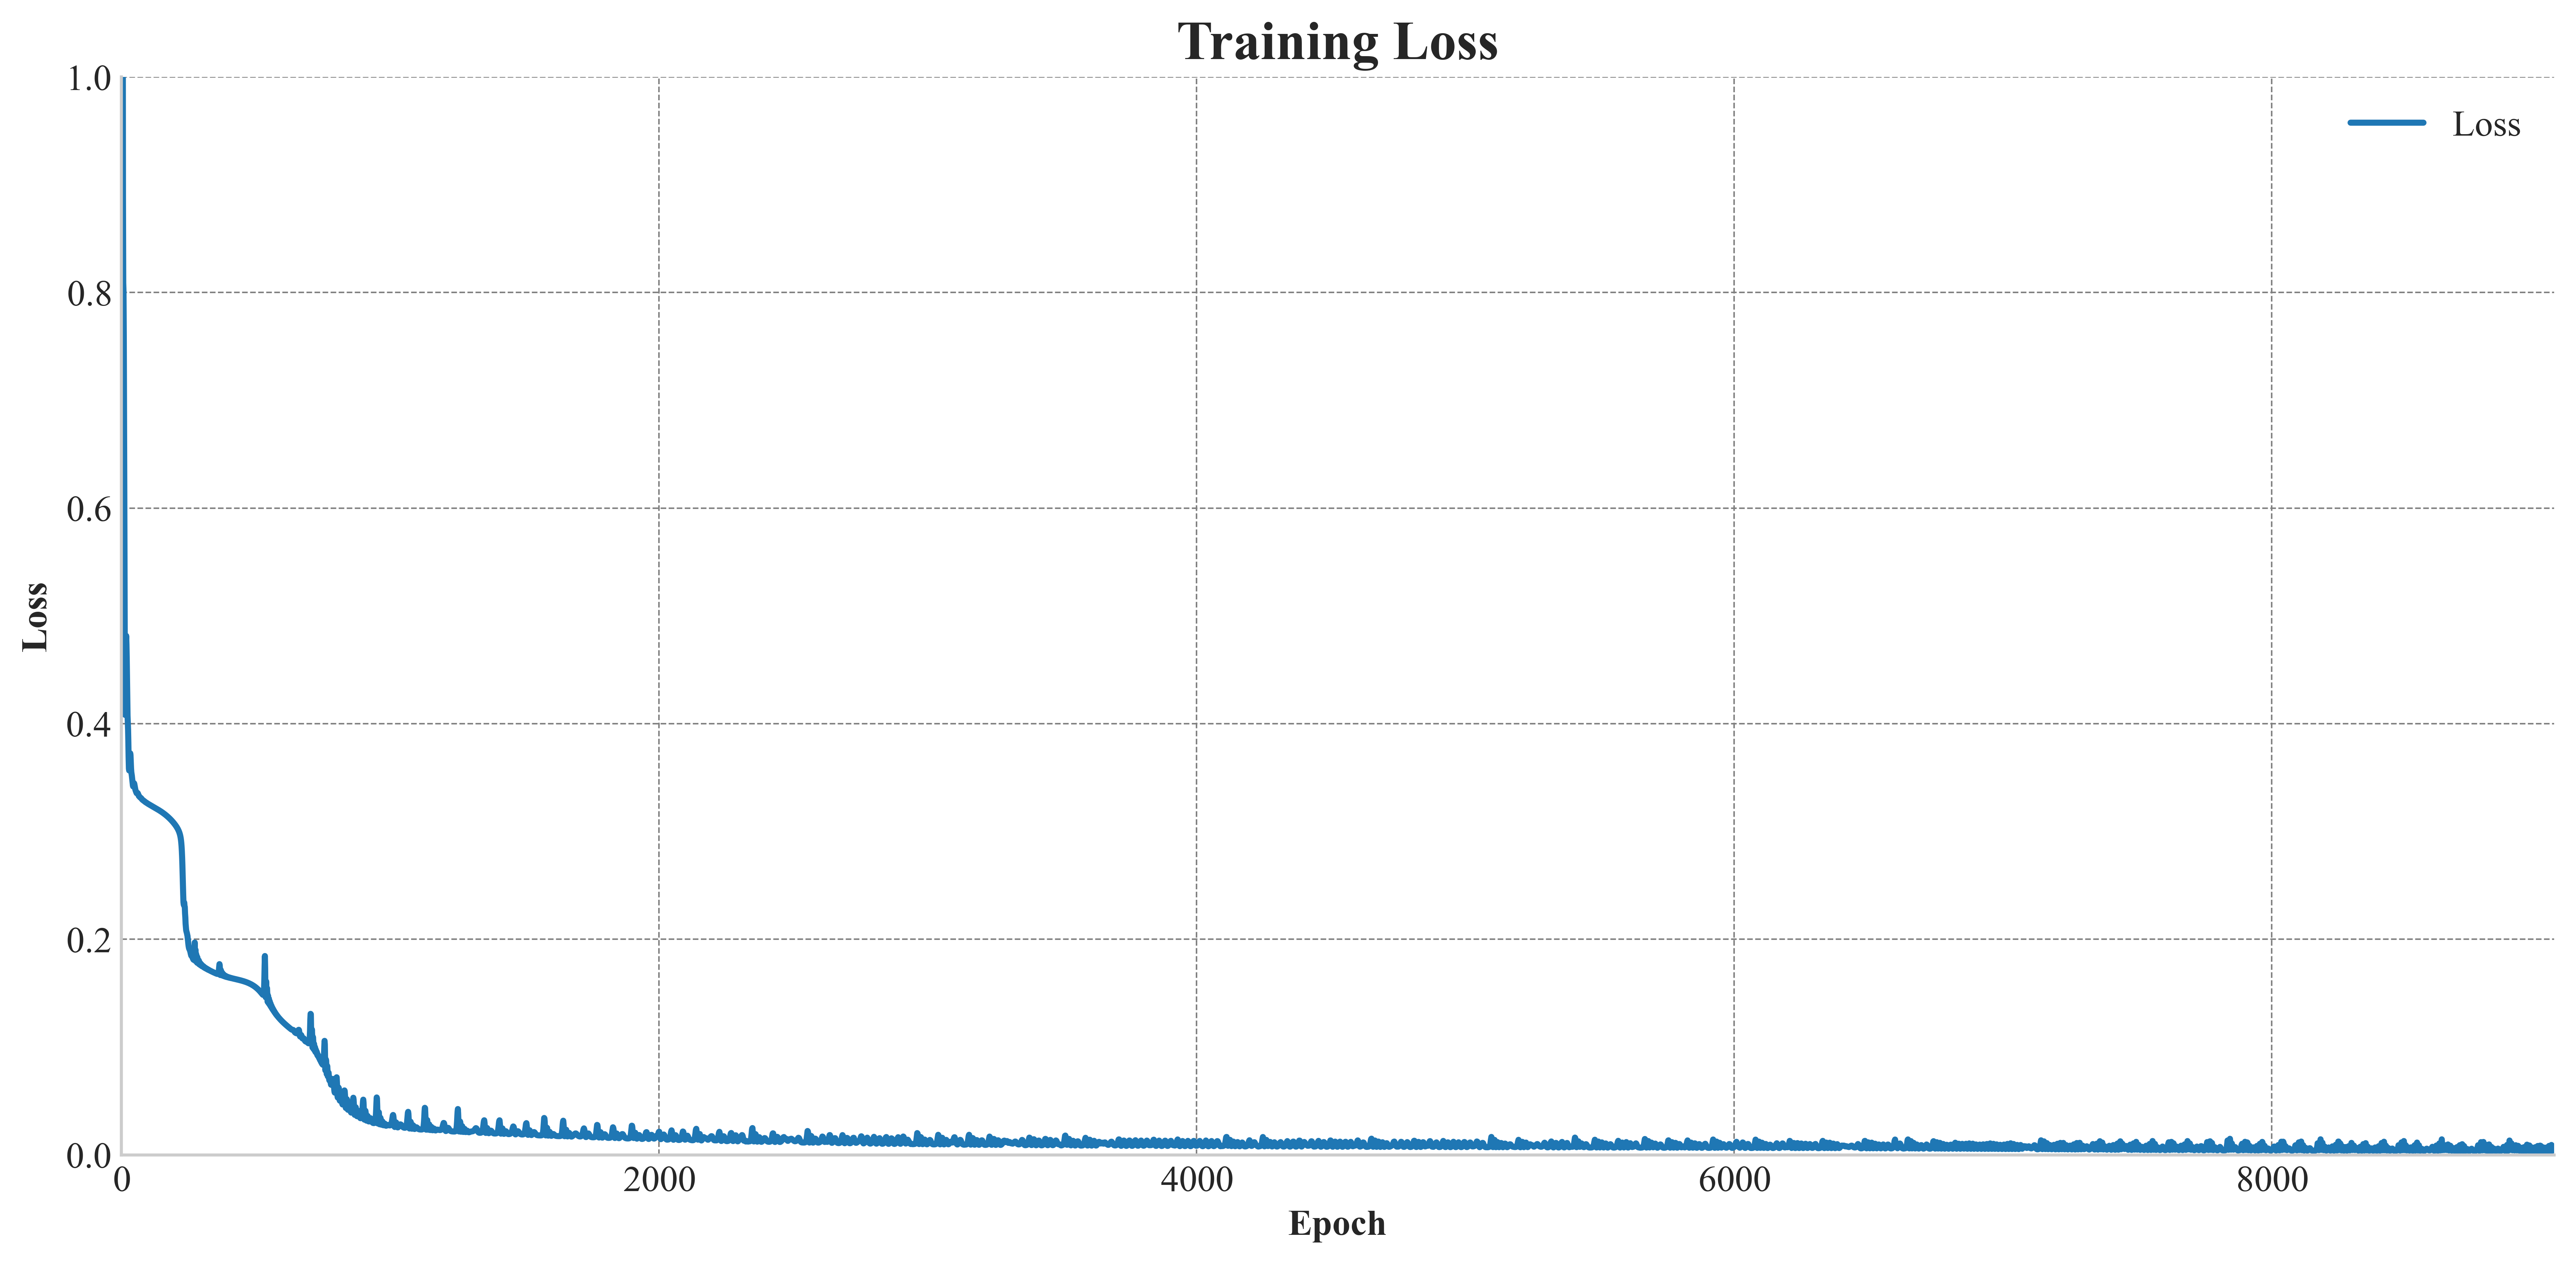

In [20]:
# plot the losses
plt.figure(figsize=(12, 6))
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.ylim(0, 1)
plt.show()

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_27096\3854032865.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


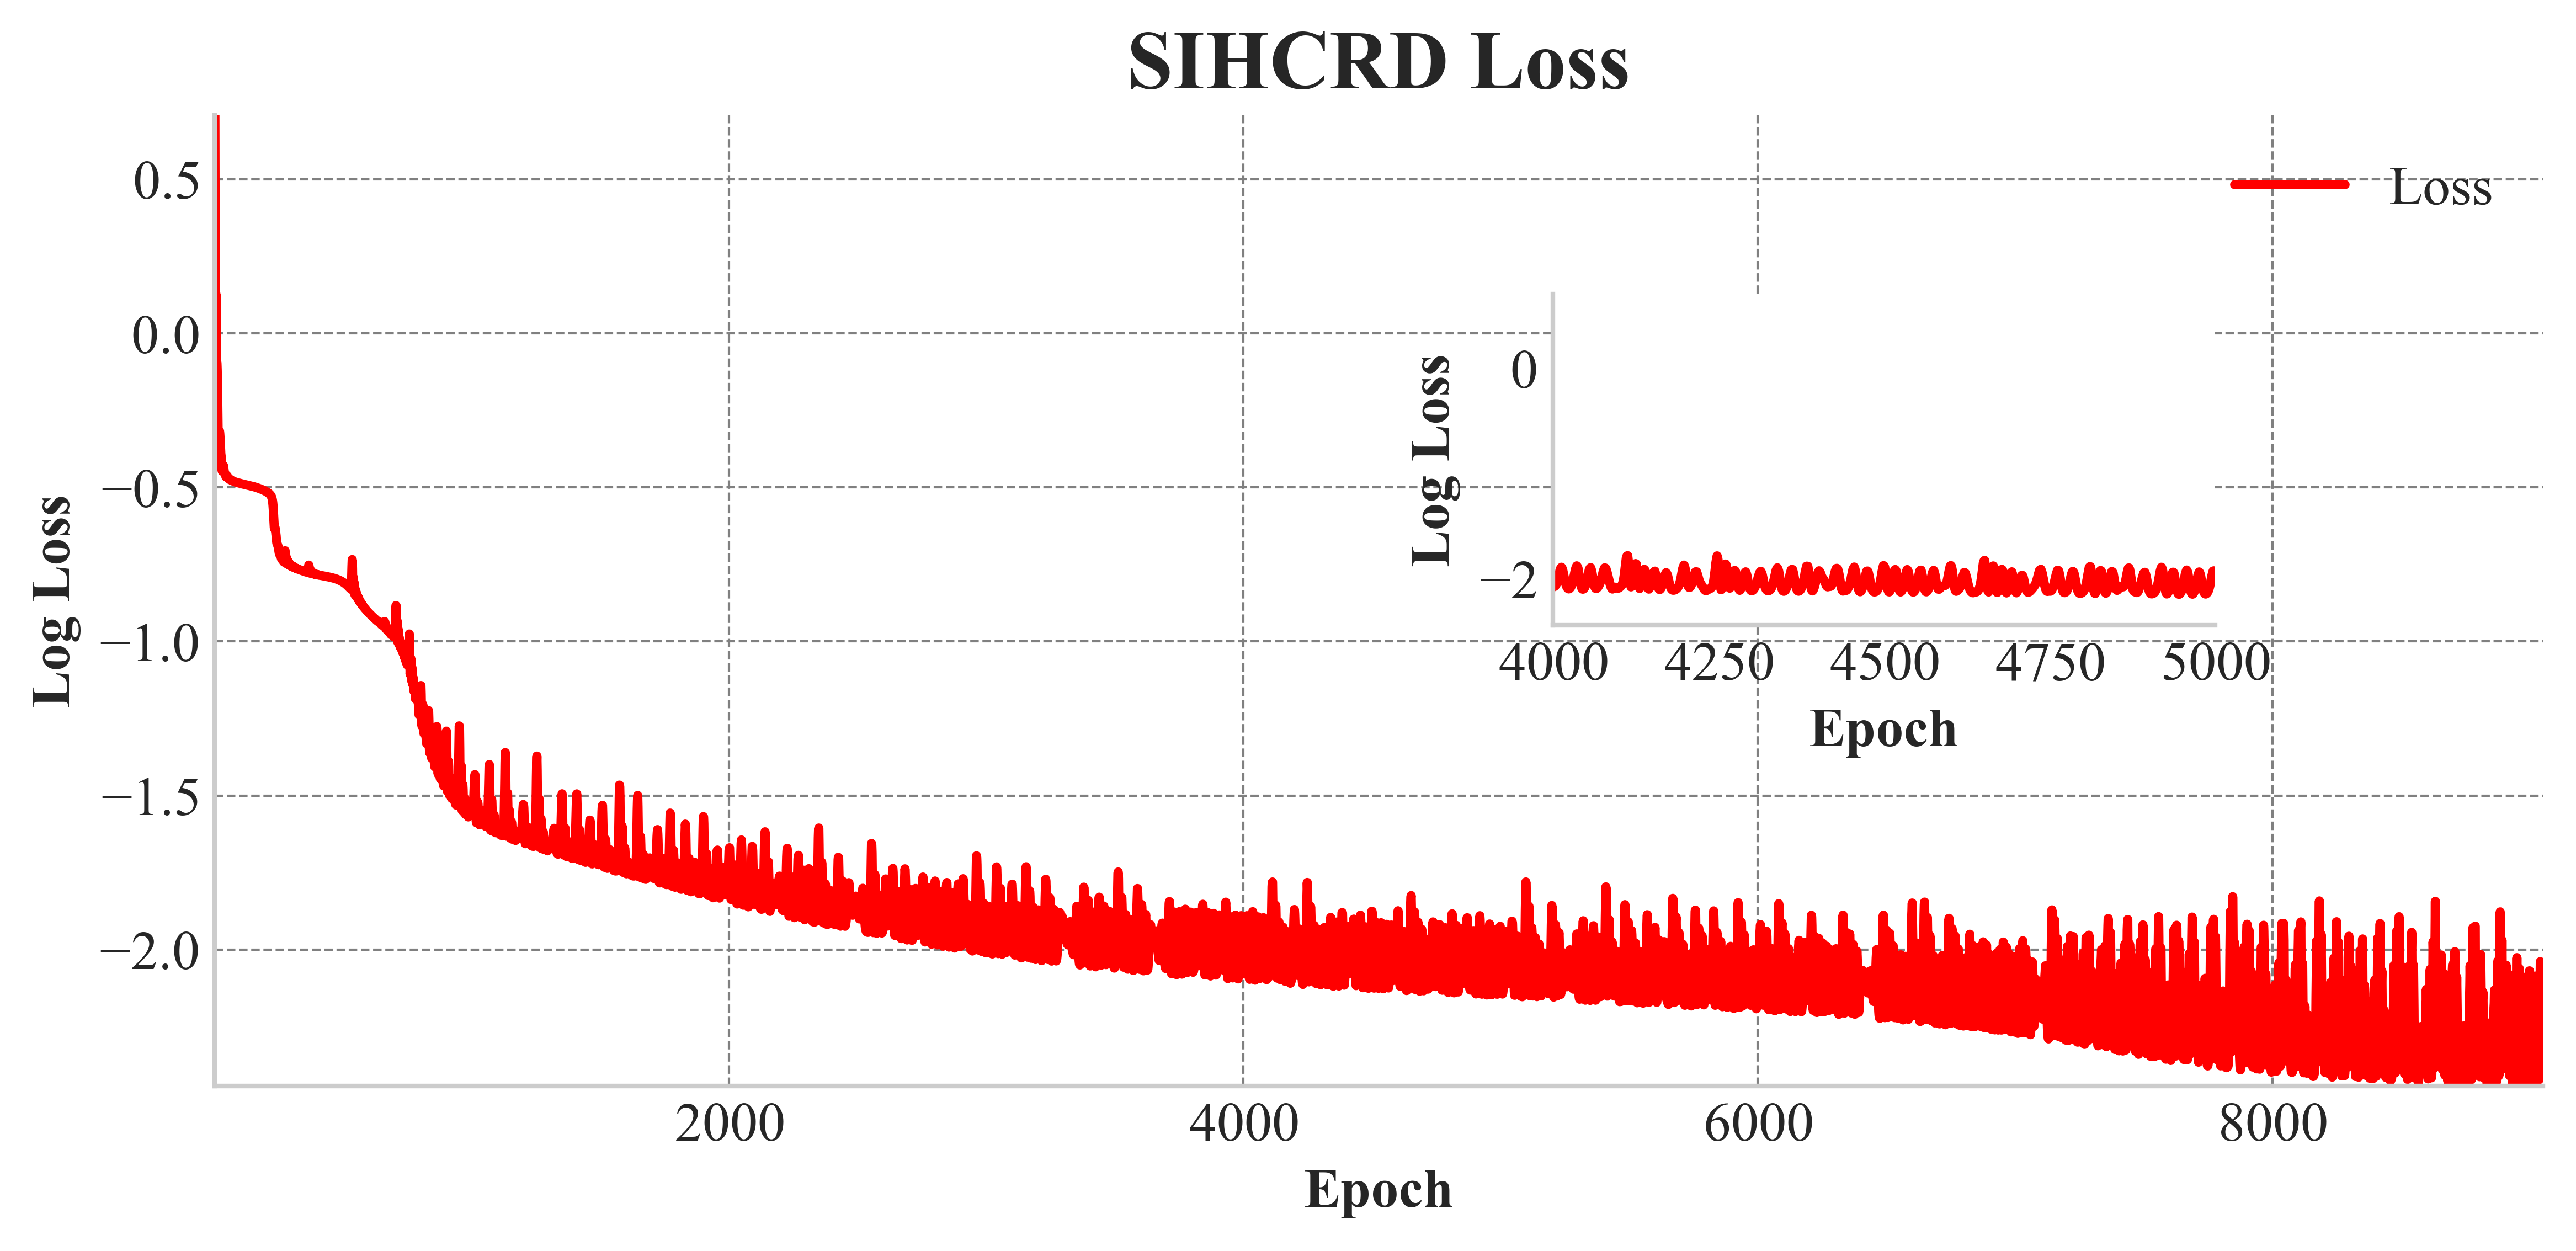

In [91]:
# function to plot the loss amd make sure it is positive and decreasing
def plot_loss(
    losses,
    title,
    save_path="../reports/figures",
    show=True,
    figsize=(8, 4),
    grid=True,
    save_format="pdf",
):
    """
    Enhanced plotting function for the training loss of a model.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "../../reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (10, 6).
    - log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Default is True.
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """

    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(losses) + 1), np.log10(losses), label="Loss", color="Red")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    
    # create a miniplot in the right corner of the zoom in plot to show the loss for epoch range 1000 to 5000
    ax = plt.axes([0.6, 0.5, 0.25, 0.25])
    ax.plot(np.arange(1, len(losses) + 1), np.log10(losses), label="Loss", color="Red")
    # ax.set_title("Zoomed In")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Log Loss")
    ax.set_xlim(4000, 5000)
    # ax.legend()
    
    plt.tight_layout()
    plt.grid(grid)
    plt.savefig(f"{save_path}/{title}_loss.{save_format}", format=save_format)
    if show:
        plt.show()
    plt.close()
    
# Plot the training loss
plot_loss(losses, "SIHCRD", save_path="../reports/figures", show=True, save_format="pdf", grid=False)

In [92]:
# extract the parameters from the model over the training period
beta_values = model.beta.cpu().detach().numpy()
gamma_values = model.gamma.cpu().detach().numpy()
rho_values = model.rho.cpu().detach().numpy()
eta_values = model.eta.cpu().detach().numpy()
kappa_values = model.kappa.cpu().detach().numpy()
delta_values = model.delta.cpu().detach().numpy()
mu_values = model.mu.cpu().detach().numpy()
xi_values = model.xi.cpu().detach().numpy()

# save them into a dataframe
parameters = pd.DataFrame(
    {
        "beta": beta_values,
        "gamma": gamma_values,
        "rho": rho_values,
        "eta": eta_values,
        "kappa": kappa_values,
        "delta": delta_values,
        "mu": mu_values,
        "xi": xi_values,
    }
)

parameters.head()


beta     gamma       rho       eta    kappa     delta        mu  \
0  0.589748  0.057255  0.018838  0.019335  0.01922  0.018869  0.019078   

         xi  
0  0.019199

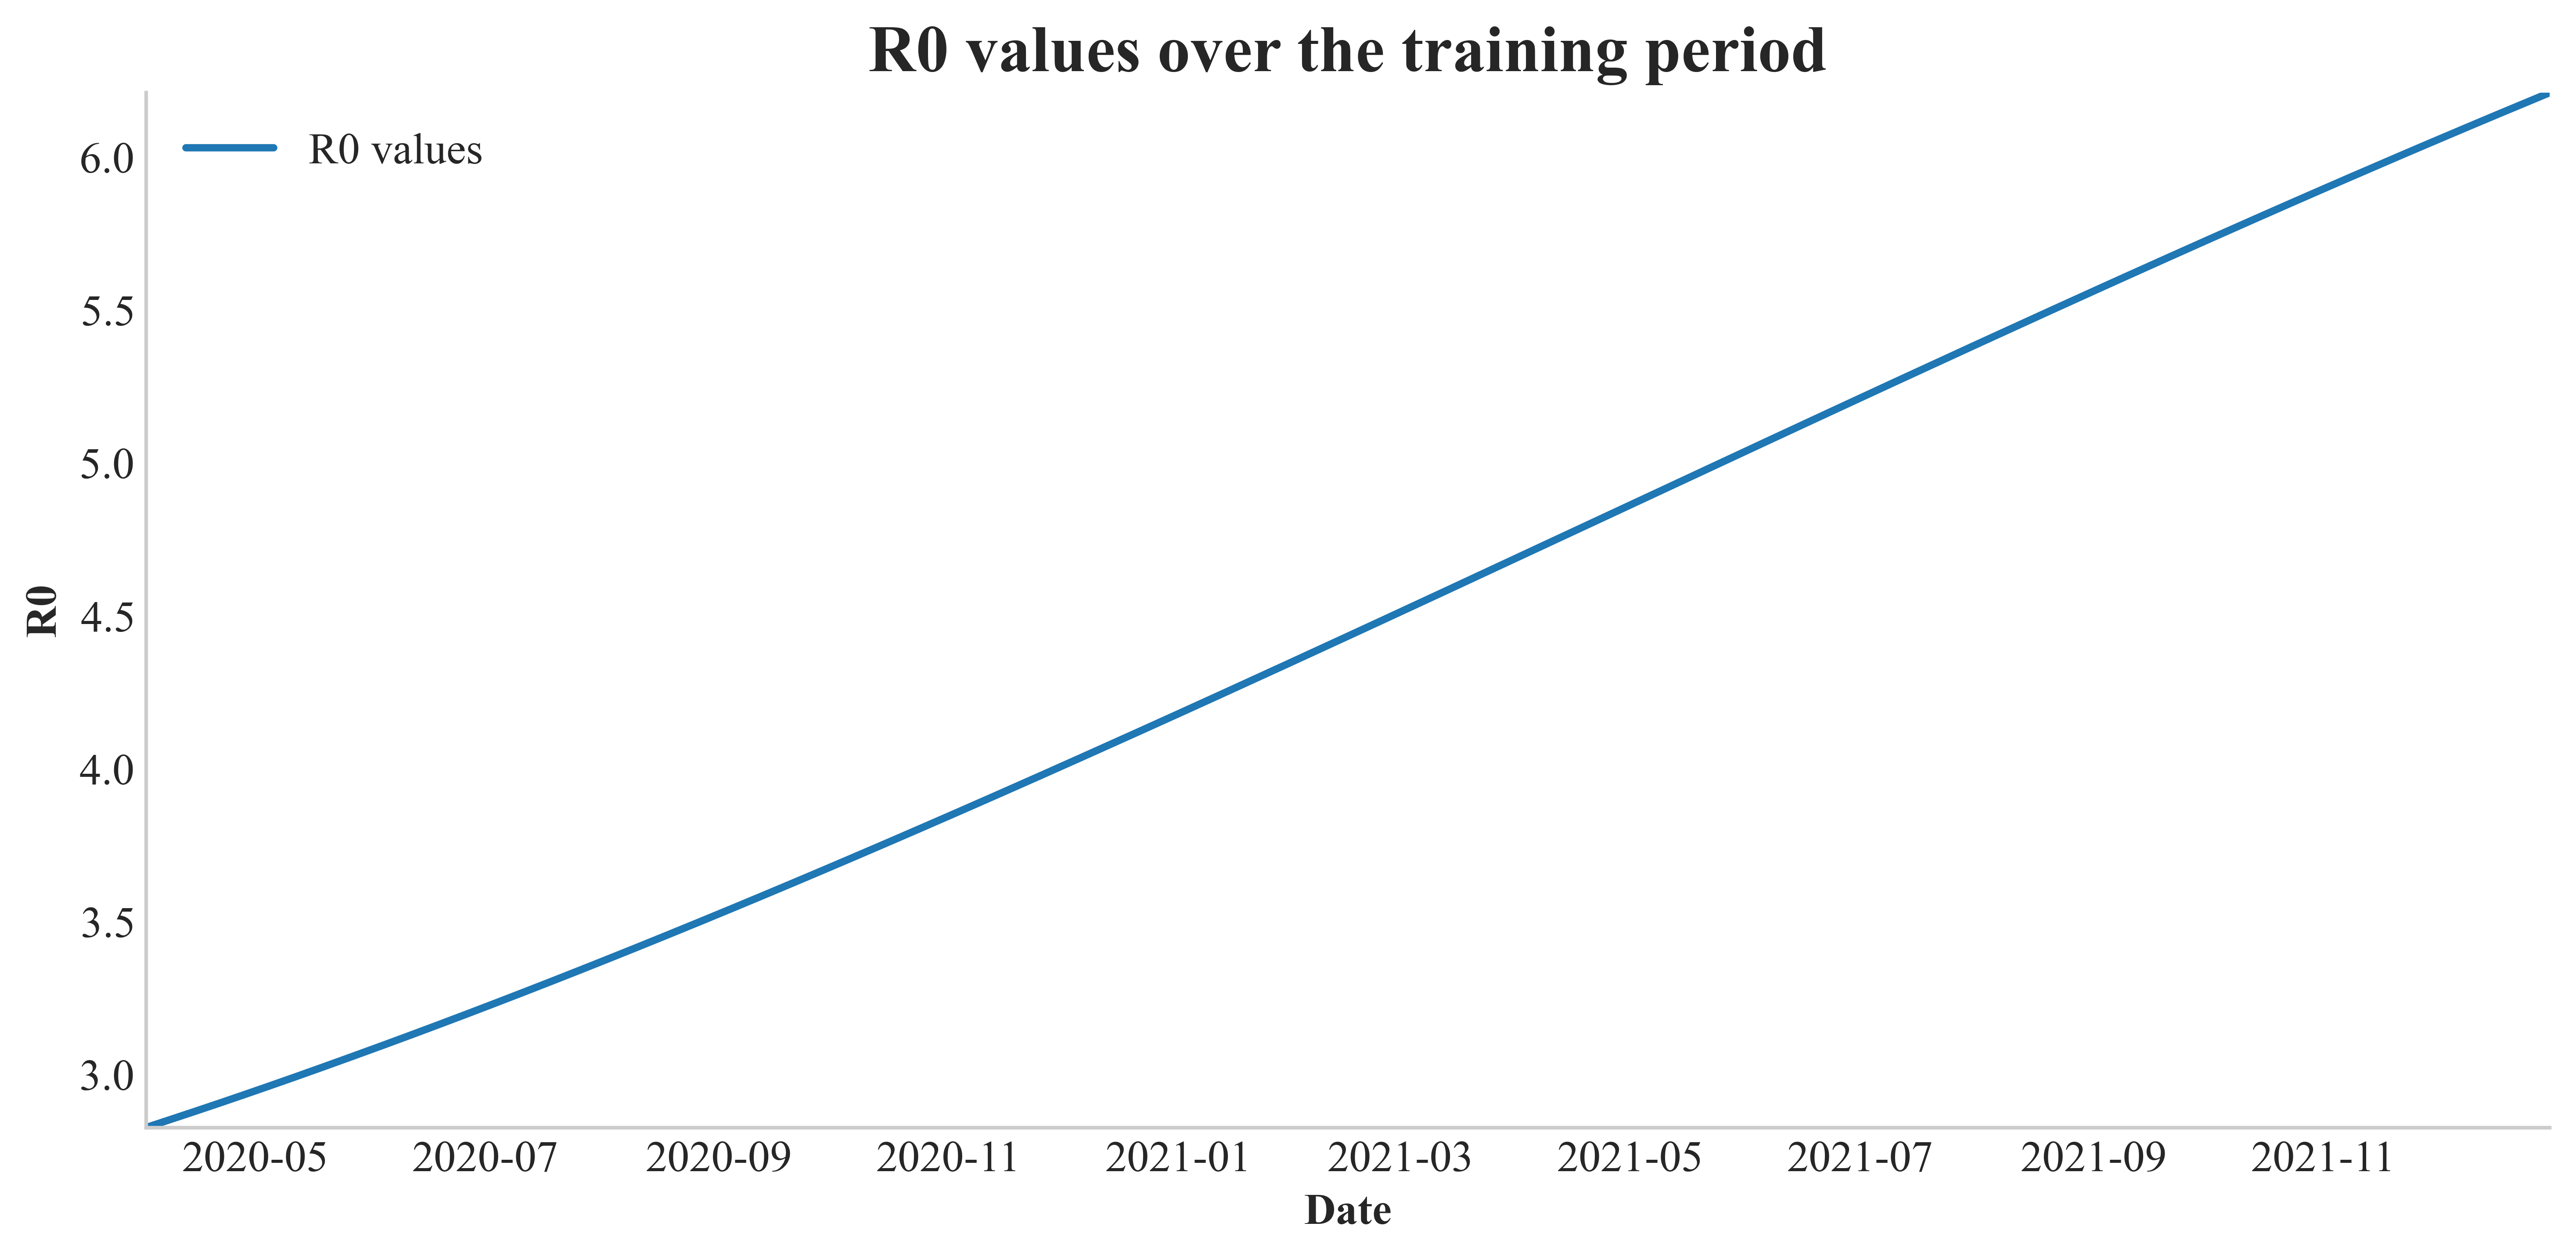

In [93]:
# plot the R0 values over the training period with the dates
dates = pd.date_range(start=train_data_start, end=train_data_end, periods=len(R0_values))

plt.figure(figsize=(10, 5))
plt.plot(dates, R0_values, label="R0 values")
plt.xlabel("Date")
plt.ylabel("R0")
plt.title("R0 values over the training period")
plt.legend()
plt.grid()
plt.show()

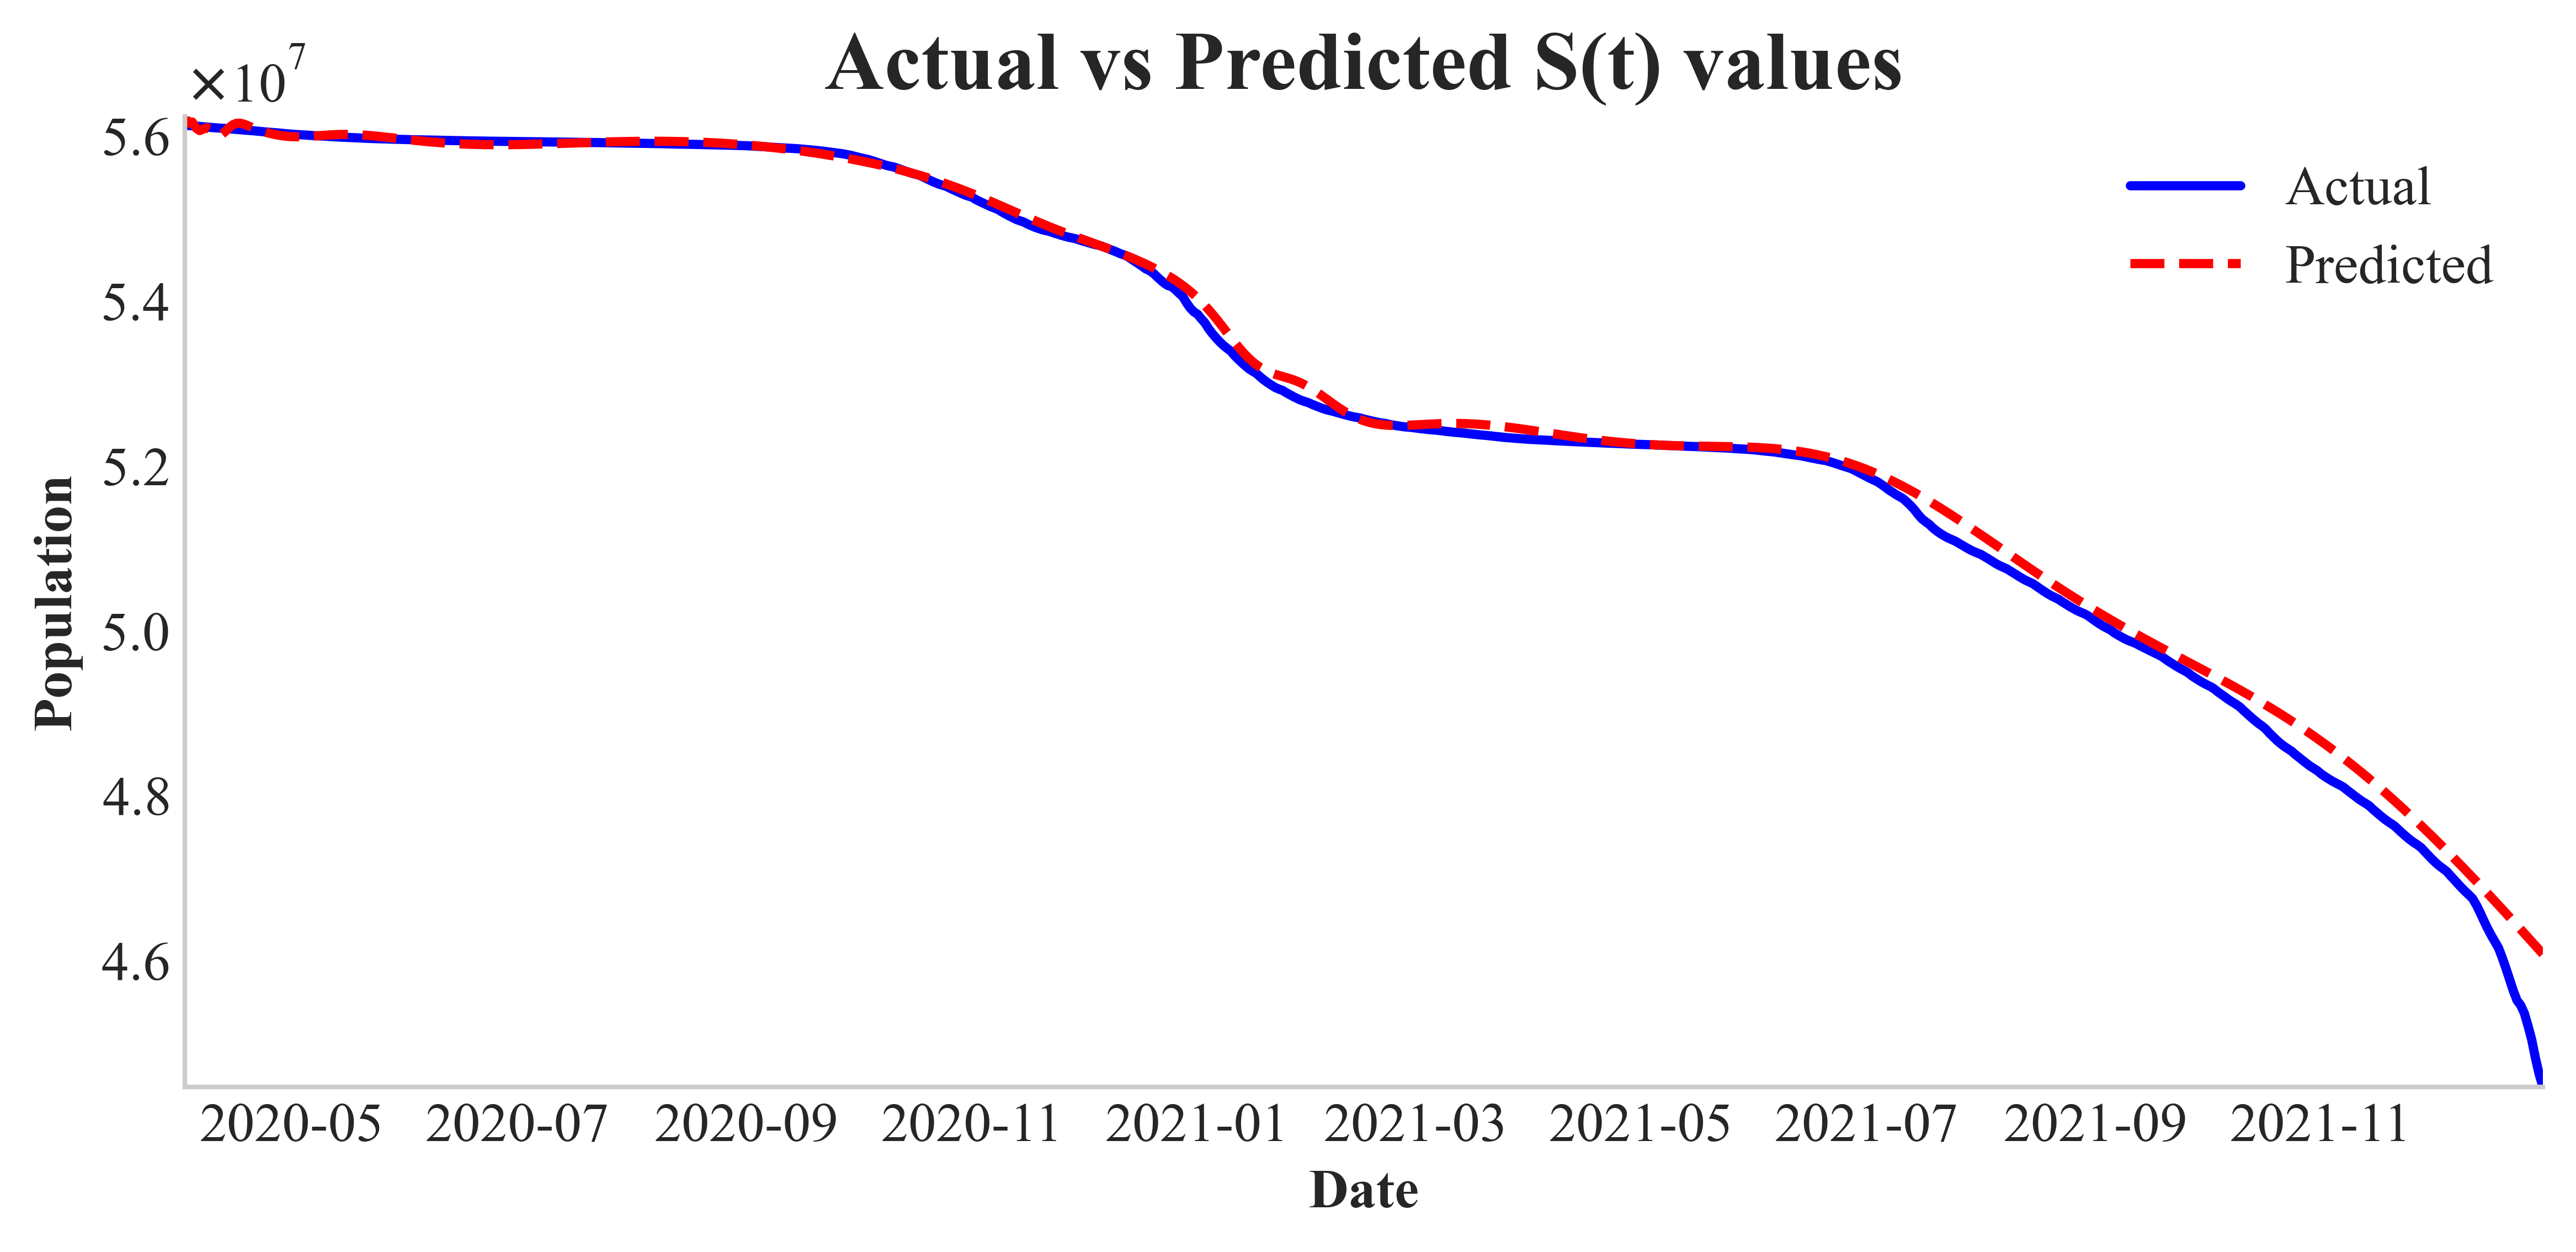

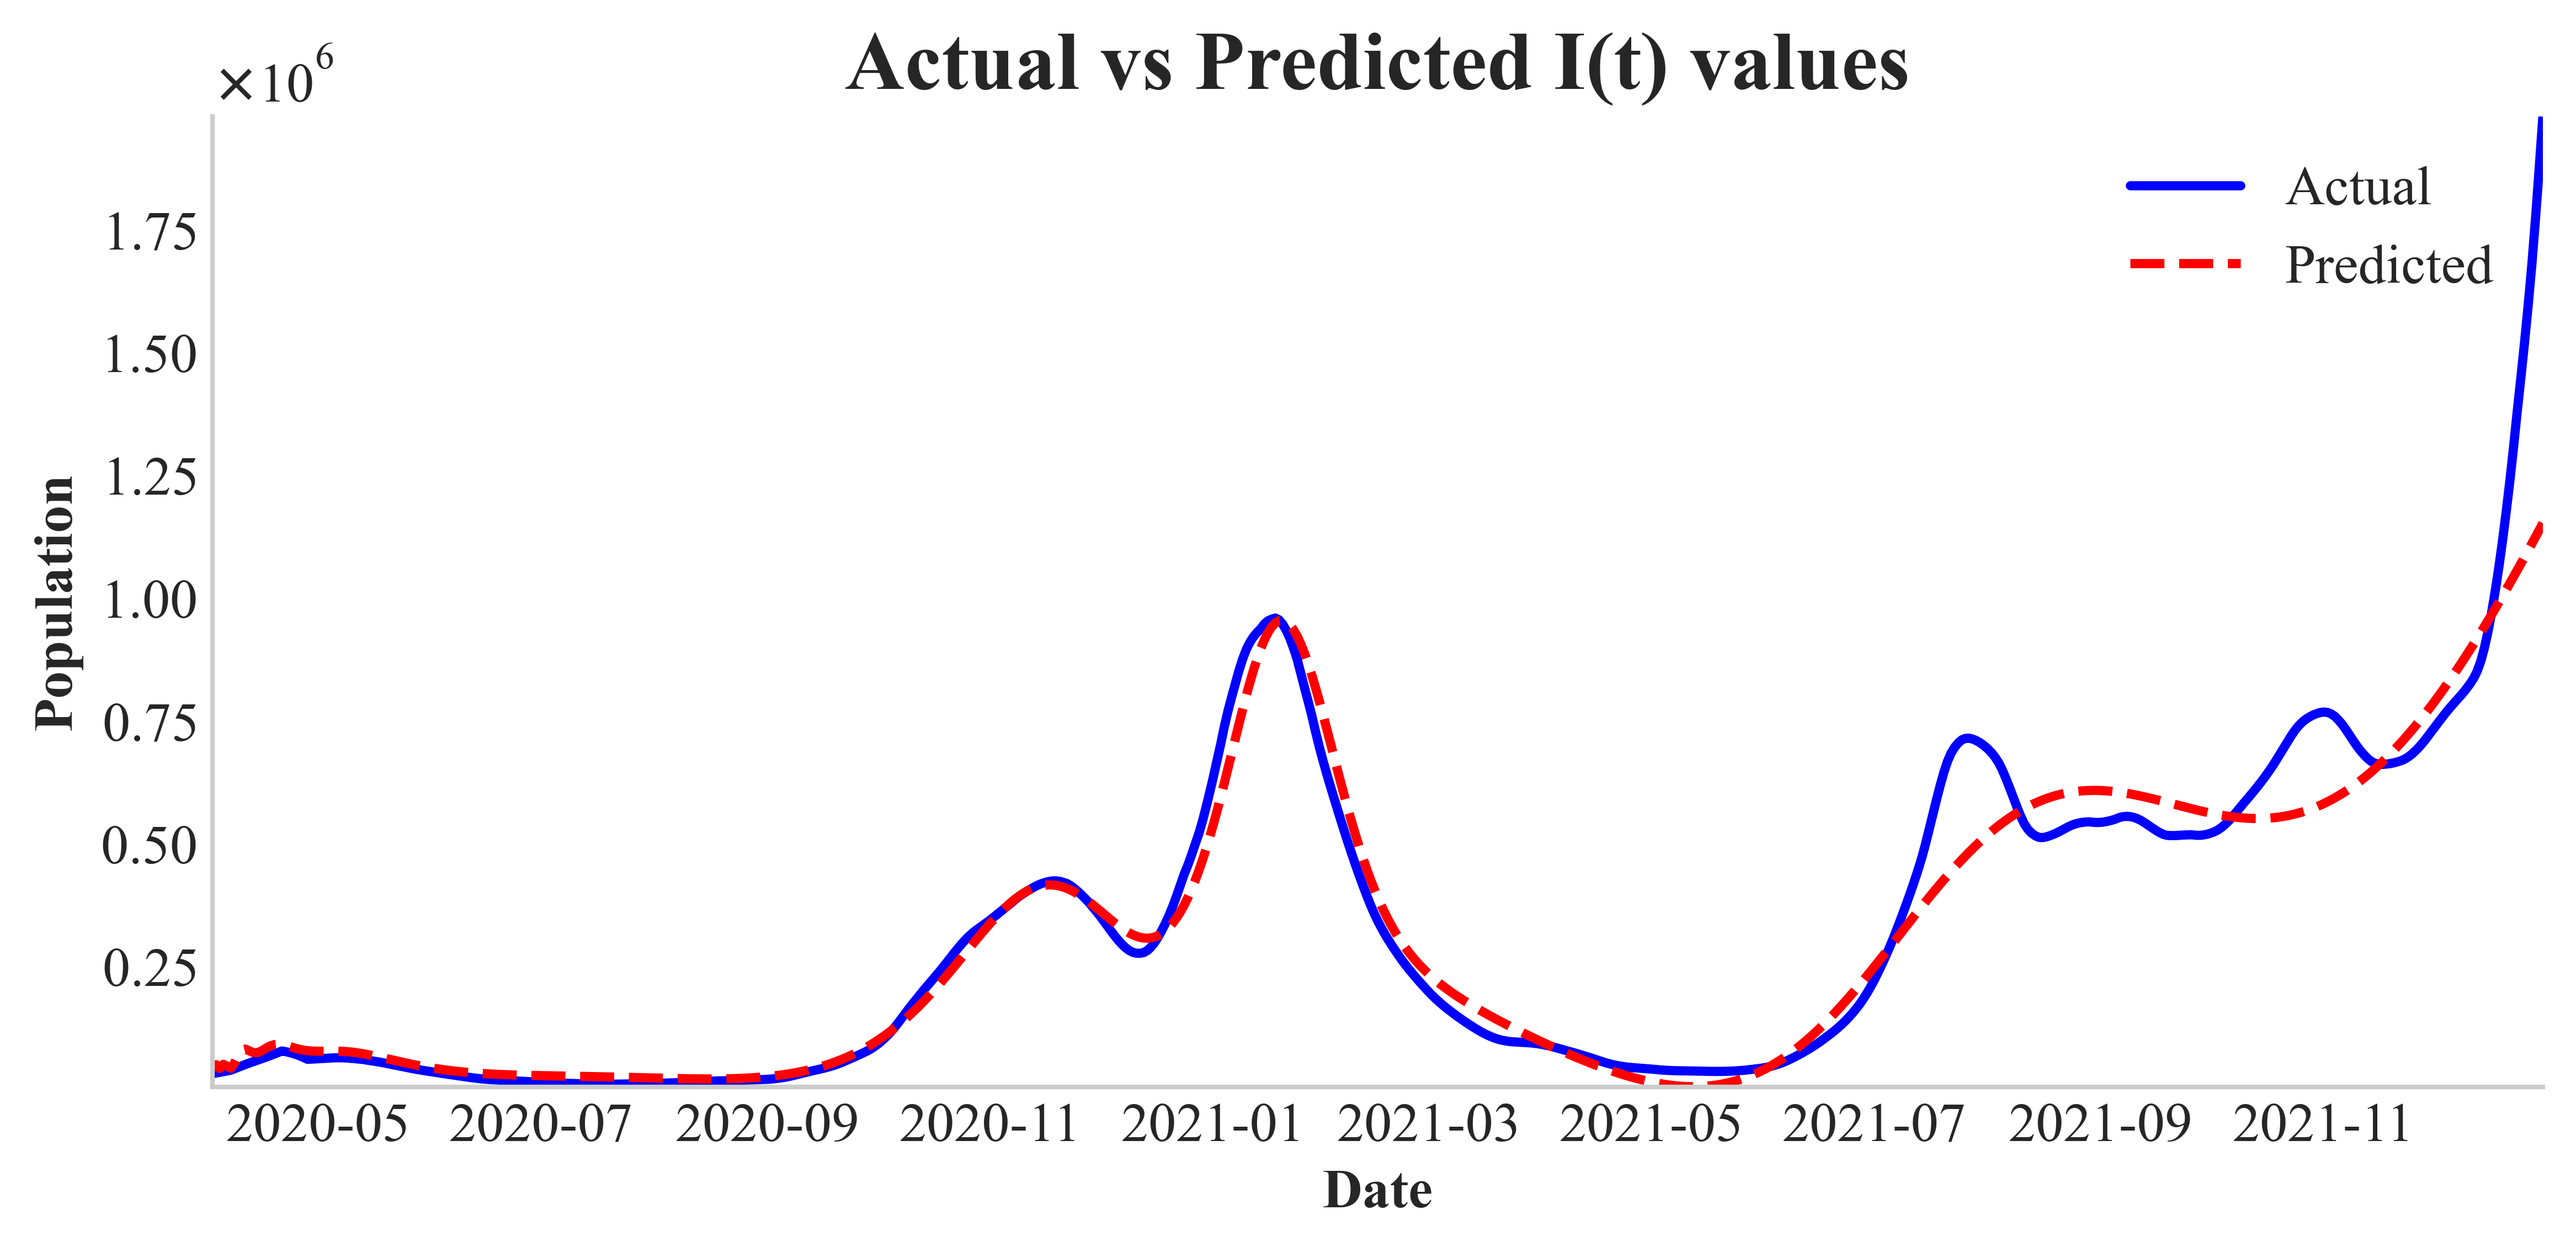

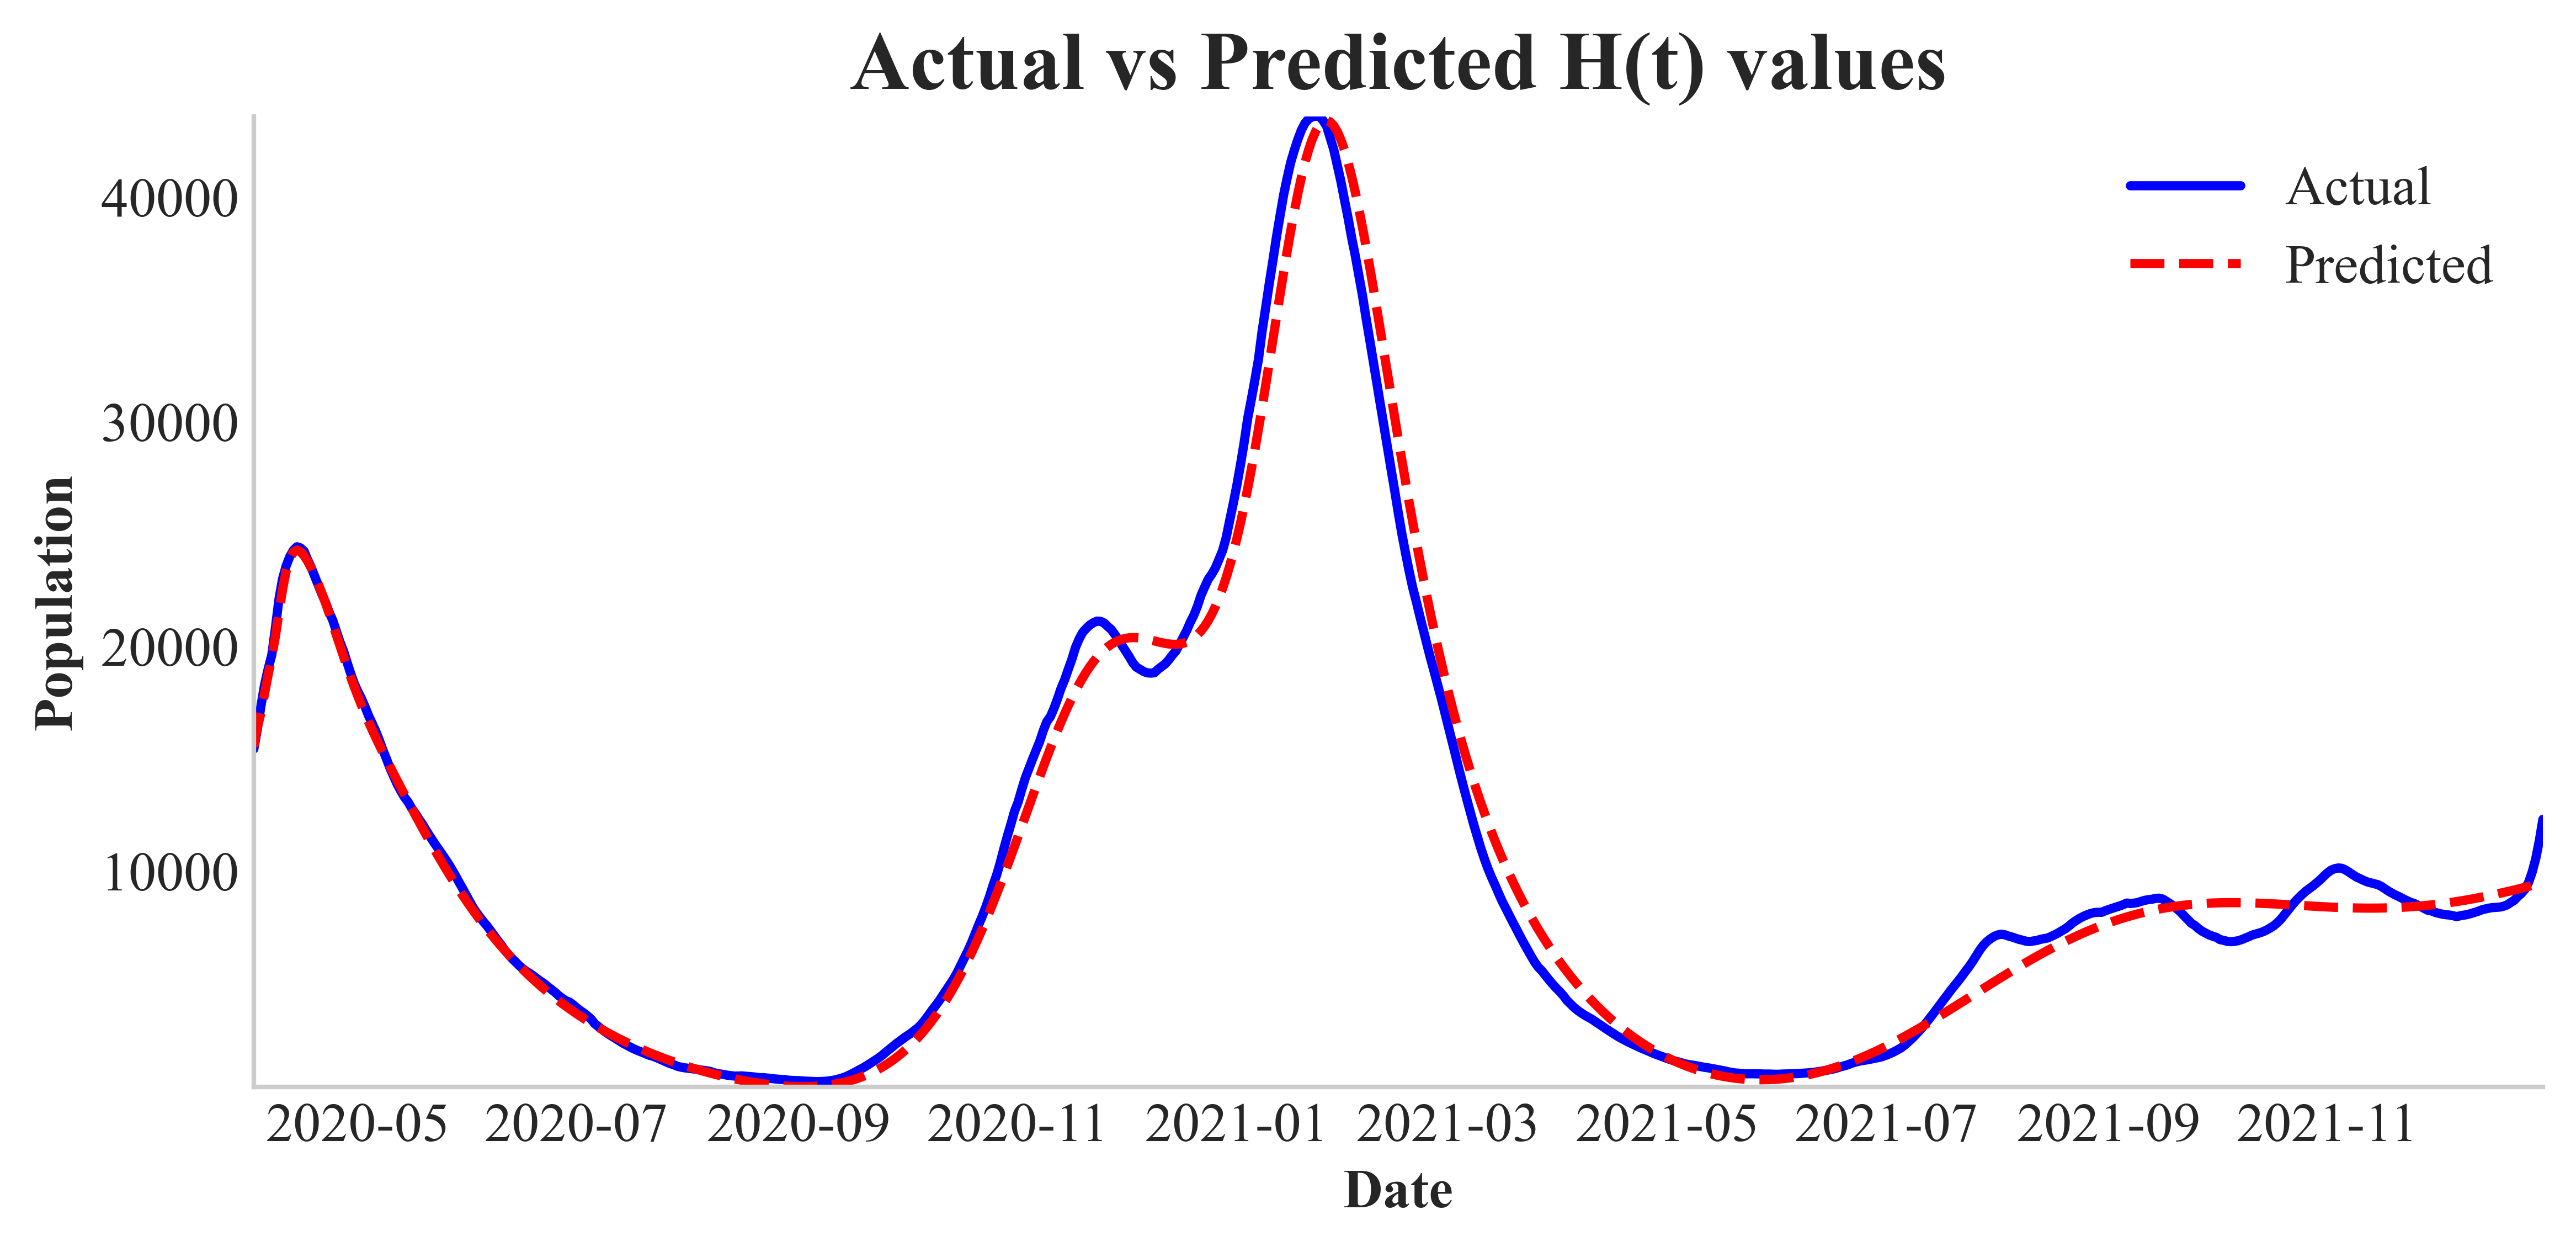

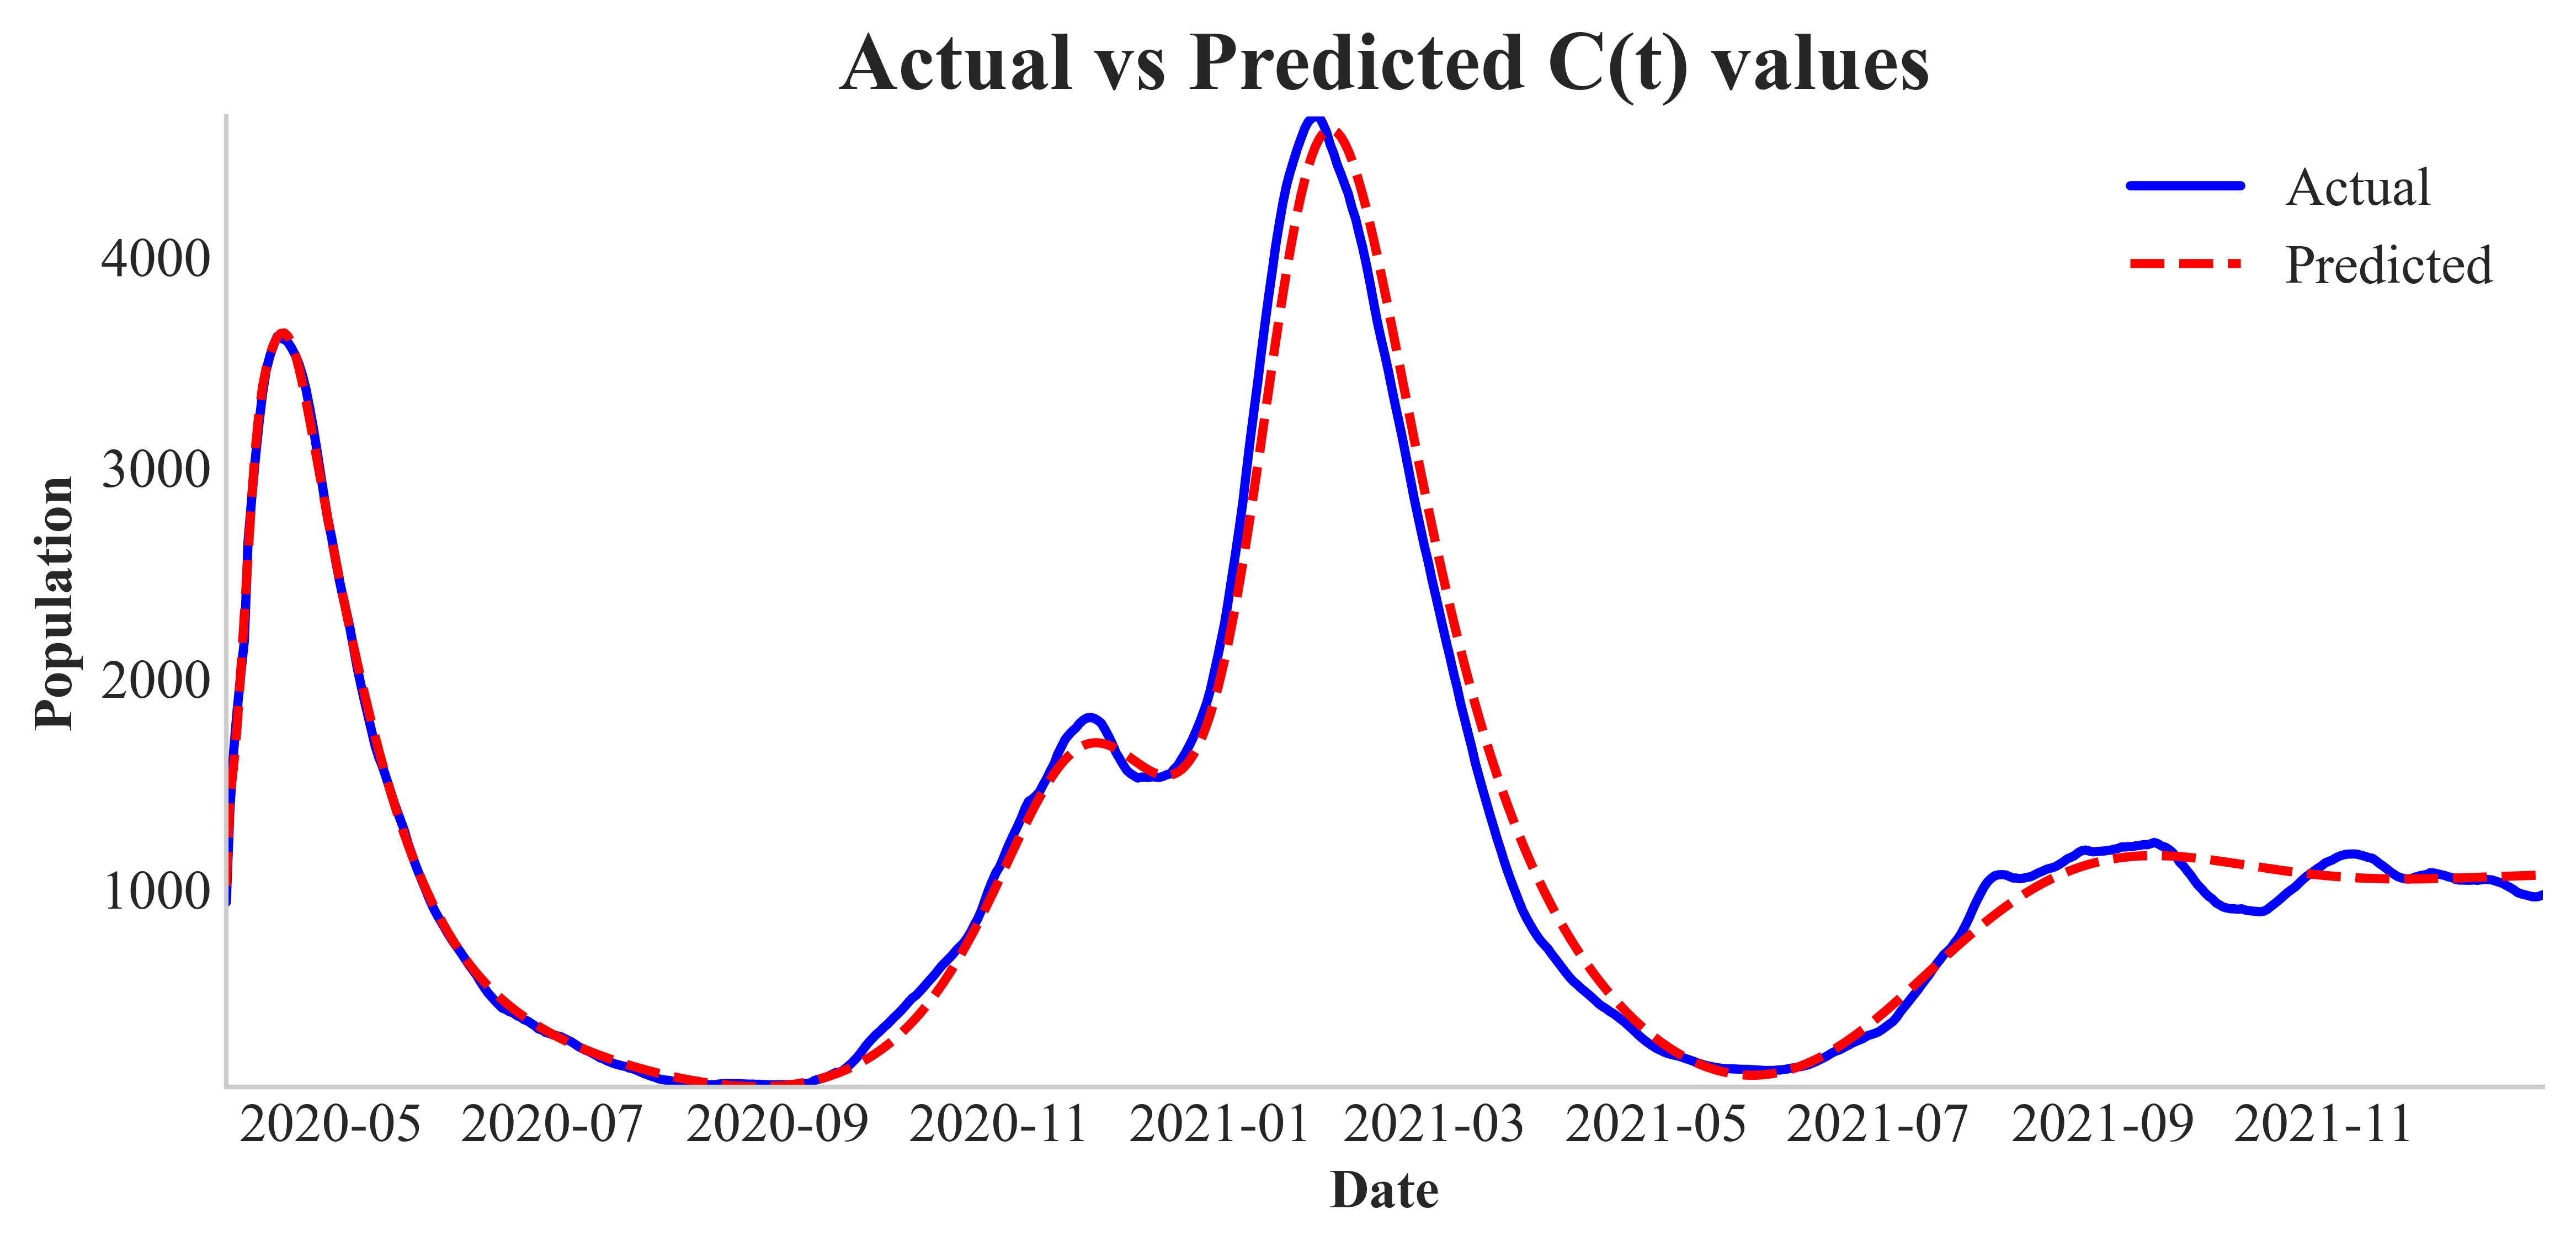

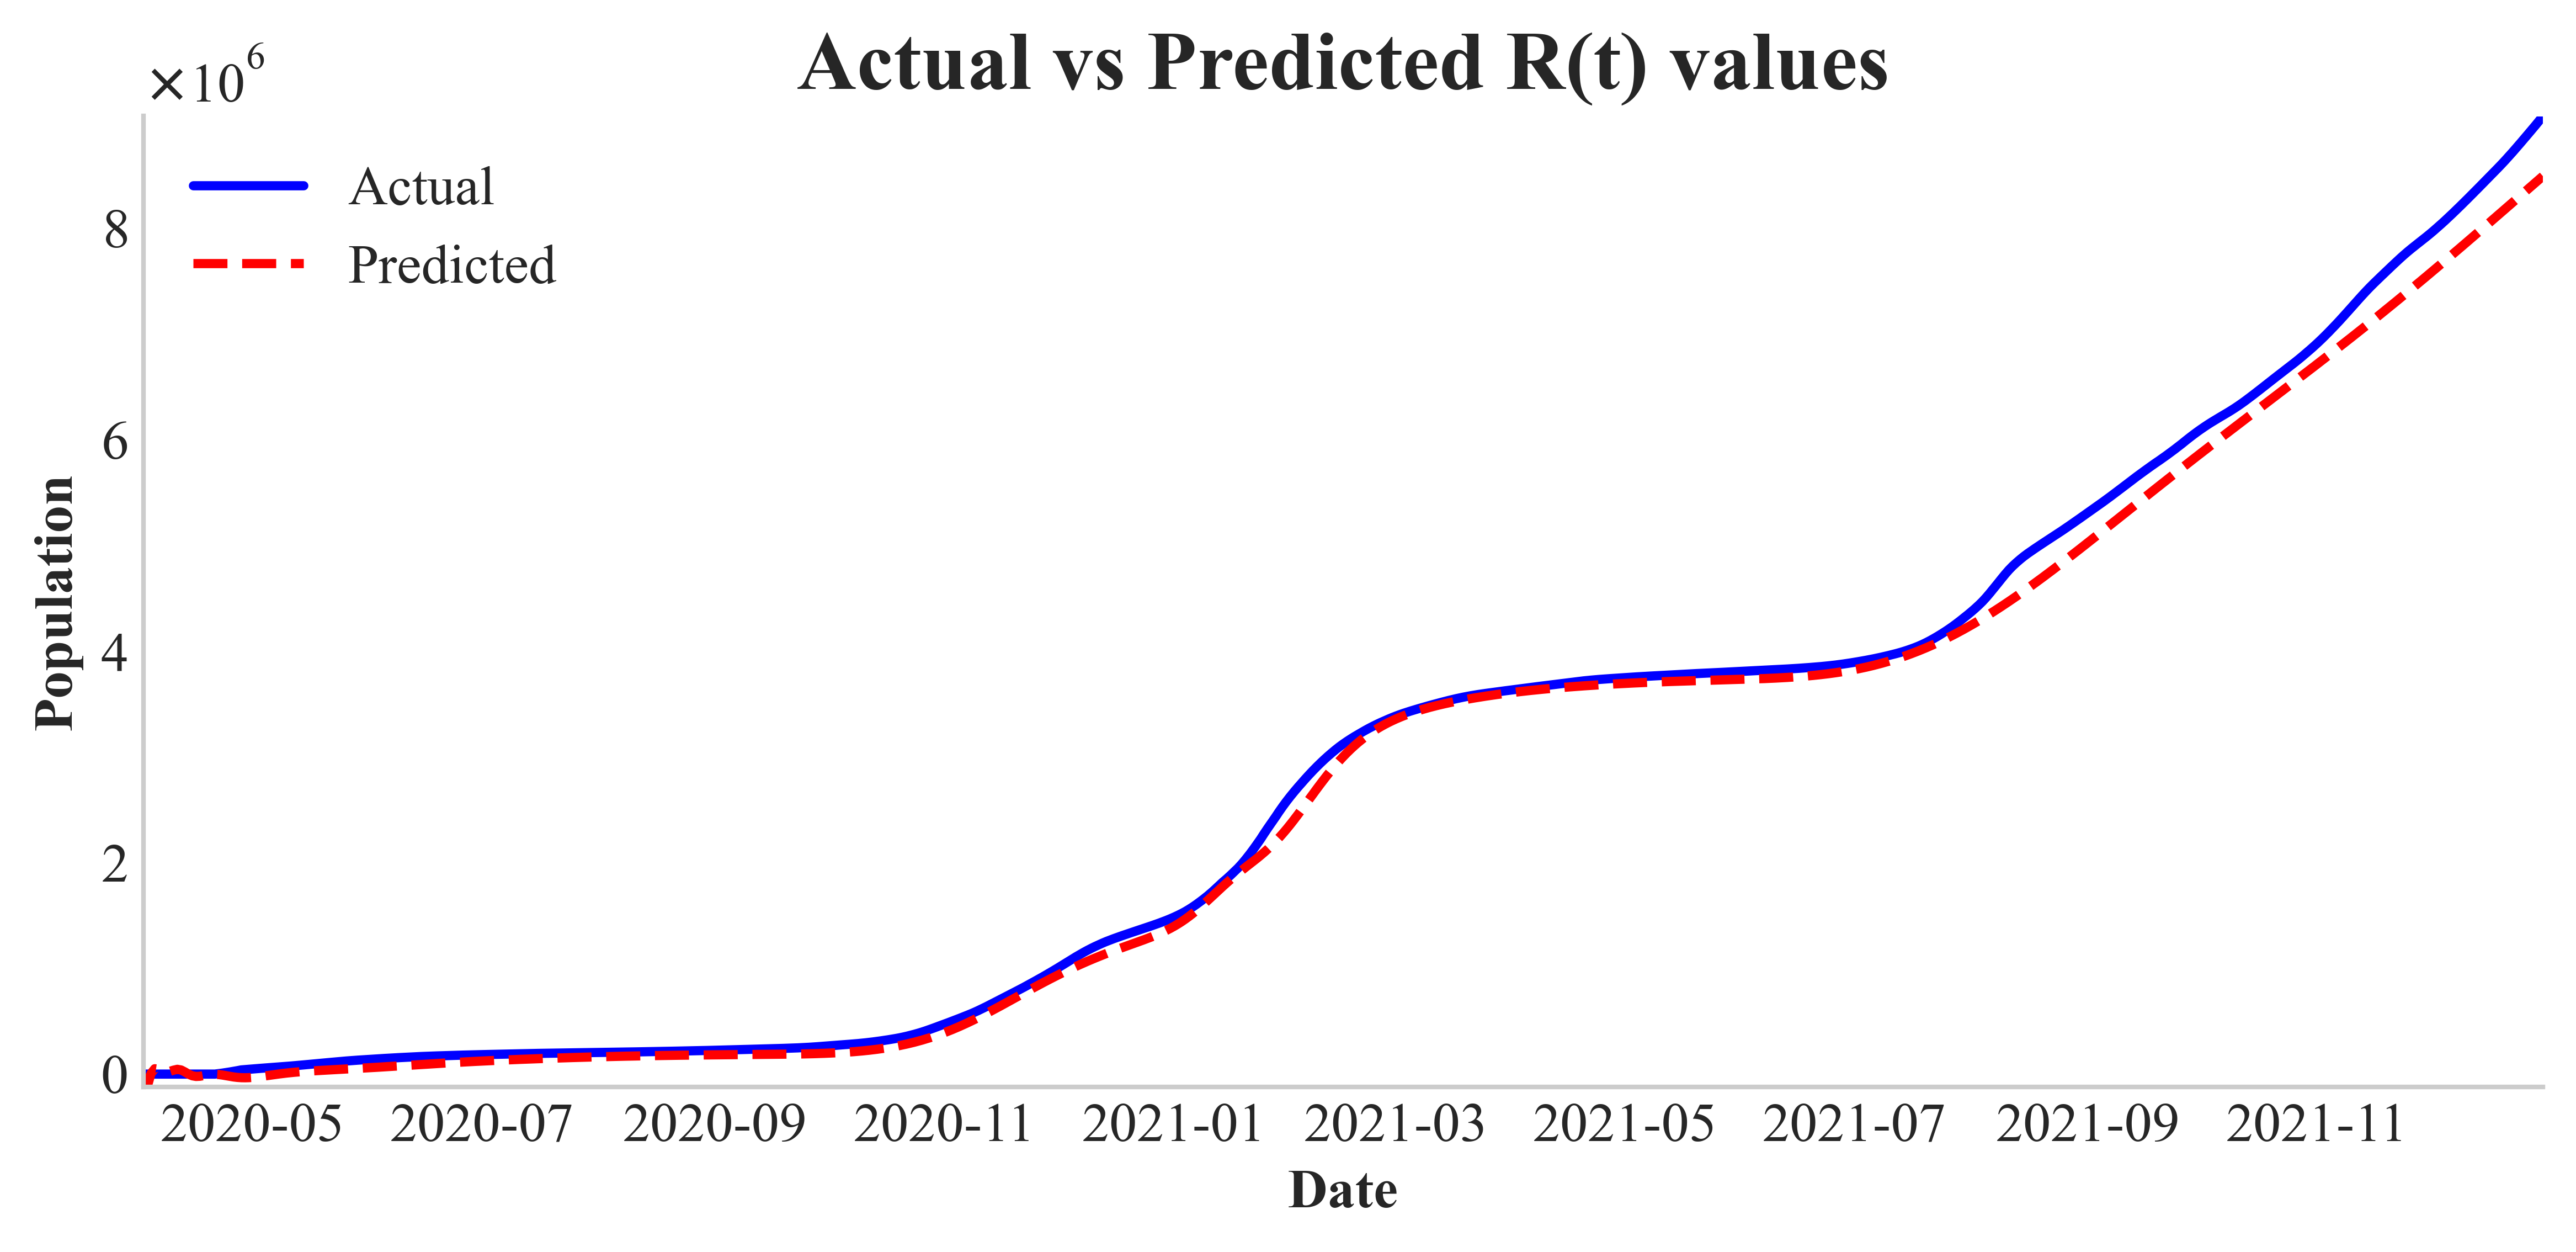

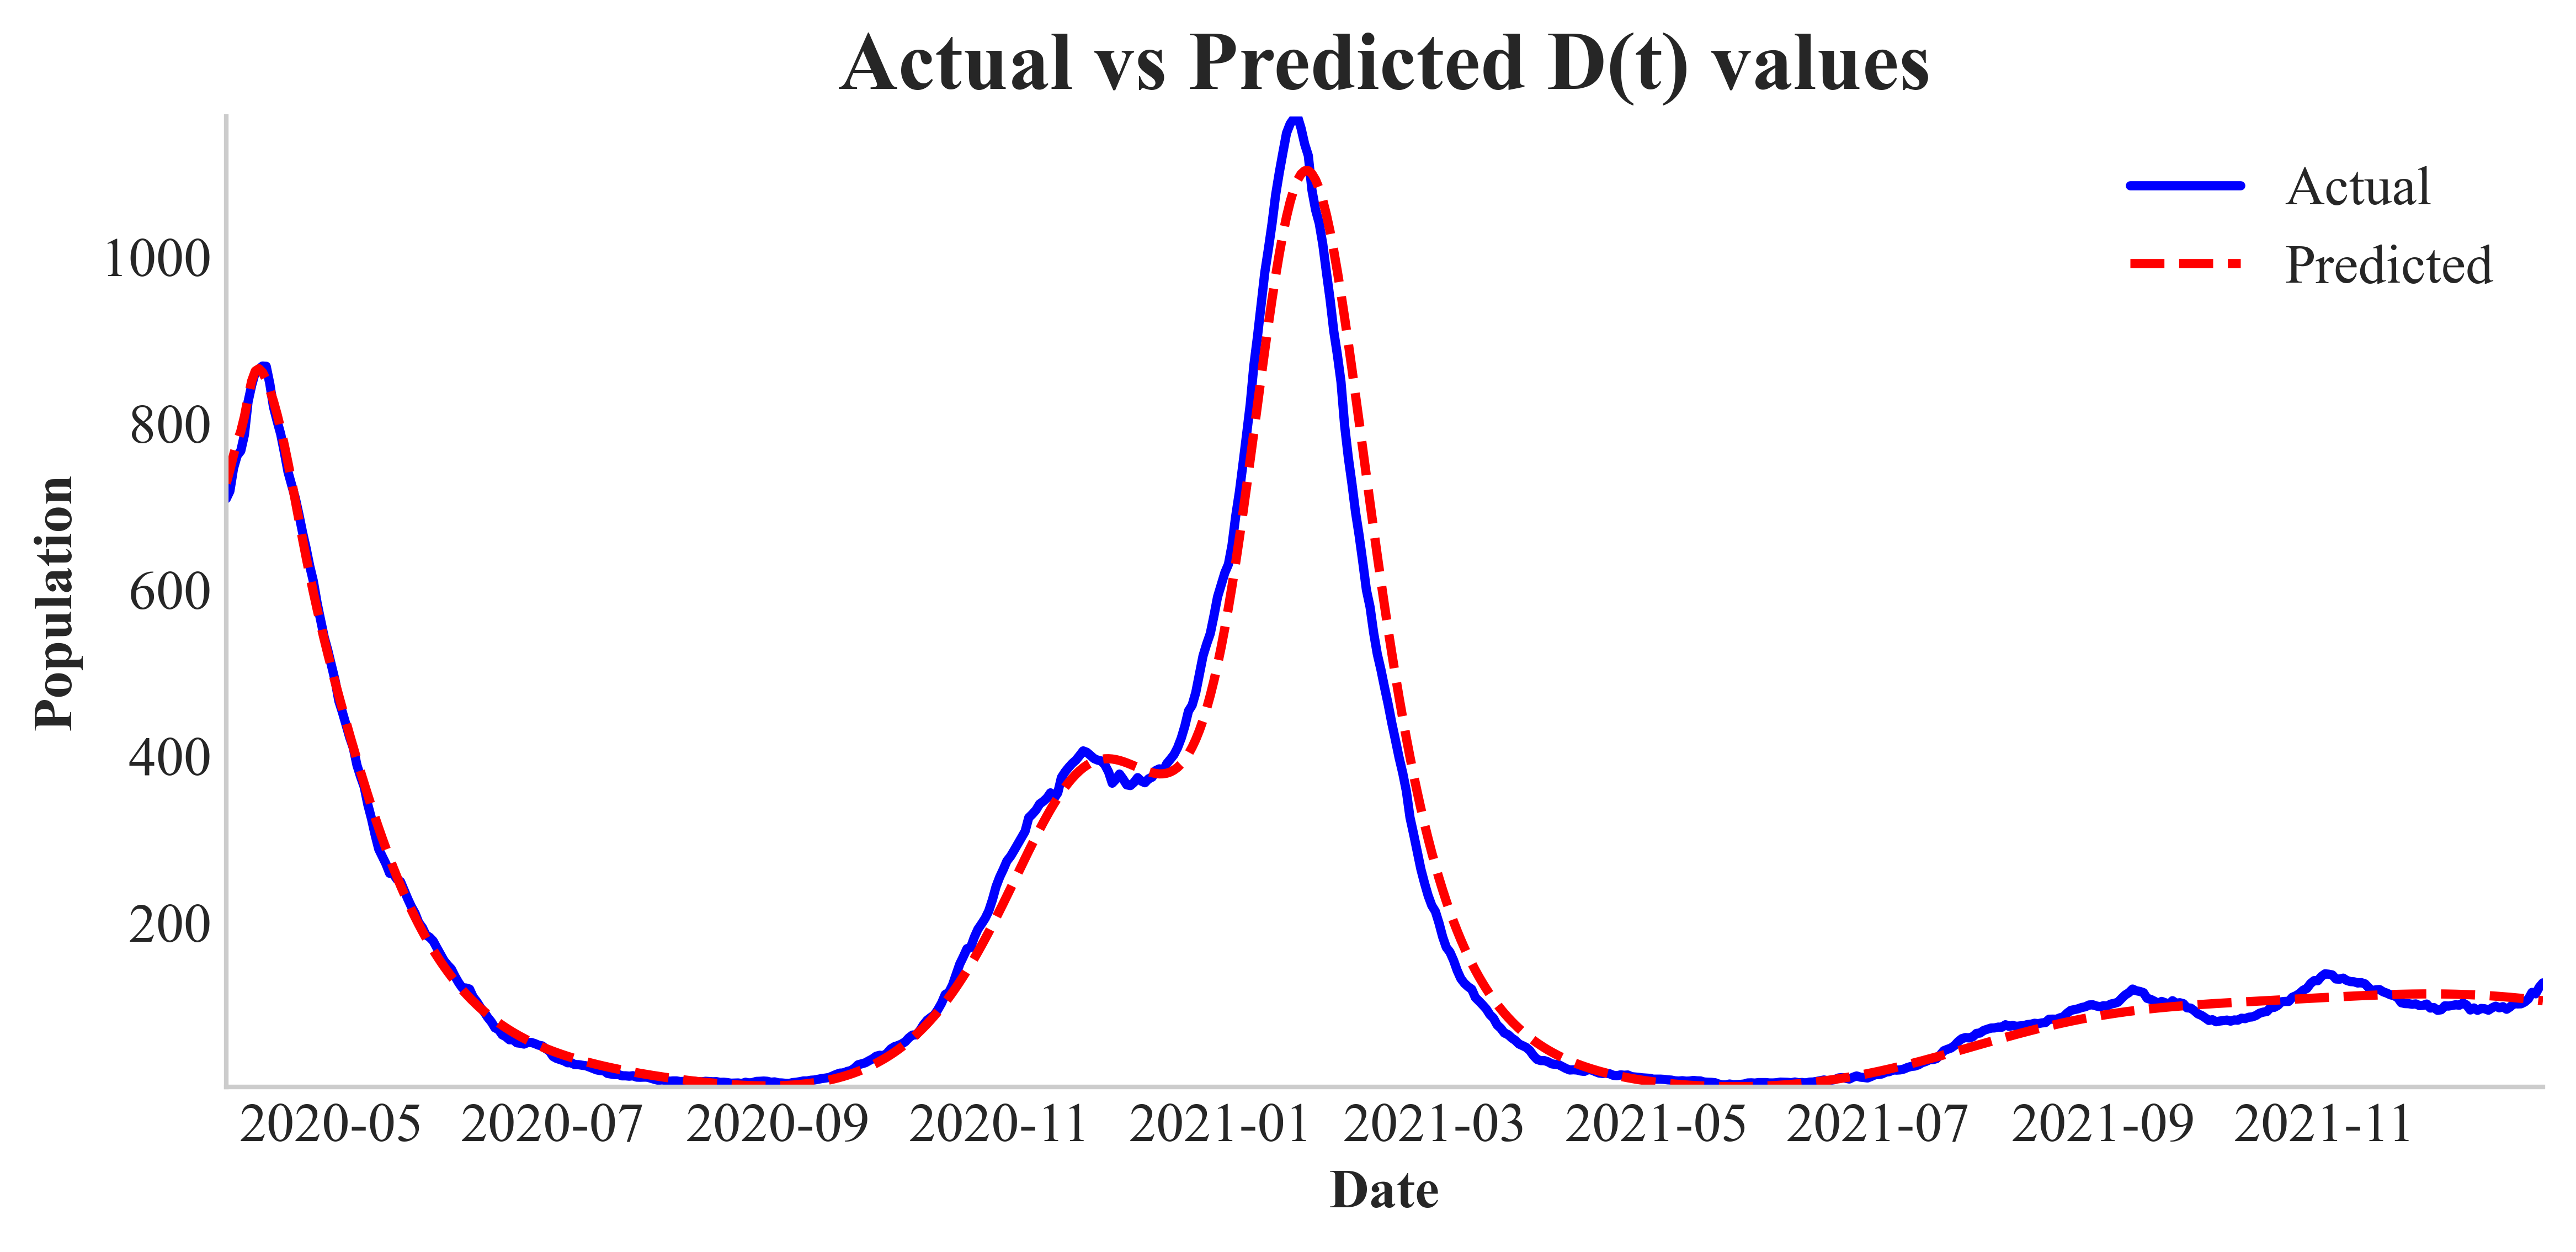

In [89]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

model.eval()

with torch.no_grad():
    predictions = model(t_train).cpu()
    
# Extract the predicted values
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = (
    predictions[:, 0],
    predictions[:, 1],
    predictions[:, 2],
    predictions[:, 3],
    predictions[:, 4],
    predictions[:, 5],
)

# Inverse transform the scaled predictions
predictions = pd.DataFrame(
    scaler.inverse_transform(
        np.concatenate(
            [
                S_pred.view(-1, 1).numpy(),
                I_pred.view(-1, 1).numpy(),
                H_pred.view(-1, 1).numpy(),
                C_pred.view(-1, 1).numpy(),
                R_pred.view(-1, 1).numpy(),
                D_pred.view(-1, 1).numpy(),
            ],
            axis=1,
        )
    ),
    columns=["S(t)", "I(t)", "H(t)", "C(t)", "R(t)", "D(t)"],
)

# Add the date column to the predictions
predictions["date"] = pd.date_range(
    start=train_data_start, end=train_data_end, periods=len(predictions)
)

# extract the actual values from the train data
S_true, I_true, H_true, C_true, R_true, D_true = (
    train_data["S(t)"].values,
    train_data["active_cases"].values,
    train_data["hospitalCases"].values,
    train_data["covidOccupiedMVBeds"].values,
    train_data["recovered"].values,
    train_data["new_deceased"].values,
)

# Create a DataFrame for the actual values
actual_values = pd.DataFrame(
    {
        "S(t)": S_true,
        "I(t)": I_true,
        "H(t)": H_true,
        "C(t)": C_true,
        "R(t)": R_true,
        "D(t)": D_true,
        "date": train_data["date"],
    }
)
# Plot the actual and predicted values for each compartment on different plots
for compartment in ["S(t)", "I(t)", "H(t)", "C(t)", "R(t)", "D(t)"]:
    plt.figure(figsize=(8, 4))
    # bar plot for the actual values
    # plt.bar(actual_values["date"], actual_values[compartment], color="blue", alpha=0.6, label="Actual")
    plt.plot(actual_values["date"], actual_values[compartment], color="blue", label="Actual")
    # line plot for the predicted values
    plt.plot(predictions["date"], predictions[compartment], color="red", label="Predicted", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Population")
    plt.title(f"Actual vs Predicted {compartment} values")
    plt.legend()
    plt.grid()
    plt.show()

# # Inverse transform the scaled predictions
# predictions = pd.DataFrame(
#     scaler.inverse_transform(
#         np.concatenate(
#             [
#                 S_pred.view(-1, 1).numpy(),
#                 I_pred.view(-1, 1).numpy(),
#                 H_pred.view(-1, 1).numpy(),
#                 C_pred.view(-1, 1).numpy(),
#                 R_pred.view(-1, 1).numpy(),
#                 D_pred.view(-1, 1).numpy(),
#             ],
#             axis=1,
#         )
#     ),
#     columns=["S(t)", "I(t)", "H(t)", "C(t)", "R(t)", "D(t)"],
# )

# # Add the date column to the predictions
# predictions["date"] = pd.date_range(
#     start=train_data_start, end=train_data_end, periods=len(predictions)
# )

# # extract the actual values from the train data
# S_true, I_true, H_true, C_true, R_true, D_true = (
#     train_data["S(t)"].values,
#     train_data["active_cases"].values,
#     train_data["hospitalCases"].values,
#     train_data["covidOccupiedMVBeds"].values,
#     train_data["recovered"].values,
#     train_data["cumulative_deceased"].values,
# )

# # Create a DataFrame for the actual values
# actual_values = pd.DataFrame(
#     {
#         "S(t)": S_true,
#         "I(t)": I_true,
#         "H(t)": H_true,
#         "C(t)": C_true,
#         "R(t)": R_true,
#         "D(t)": D_true,
#         "date": train_data["date"],
#     }
# )

# # Plot the actual and predicted values for each compartment on different plots



In [76]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


def forecast_model(initial_conditions, model_params, days, N):
    # Unpack the model parameters and convert from tensors (if applicable)
    beta, gamma, rho, eta, kappa, delta, mu, xi = [p.item() for p in model_params]  # Convert each parameter to scalar if they are single-value tensors
    
    # Ensure initial conditions are on CPU and numpy, and correctly flattened
    initial_conditions = [ic.cpu().numpy() for ic in initial_conditions]
    initial_conditions = scaler.inverse_transform(np.array(initial_conditions).reshape(1, -1))[0]  # Flatten after inverse transform
    
    # Define the model equations
    def model_eqs(t, y):
        S, I, H, C, R, D = y
        dSdt = -beta * I / N * S
        dIdt = beta * S / N * I - gamma * I - rho * I - delta * I
        dHdt = rho * I - eta * H - kappa * H
        dCdt = eta * H - mu * C - xi * C
        dRdt = gamma * I + kappa * H + mu * C
        dDdt = delta * I + xi * C
        return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]

    # Time span for the forecast
    t_span = [0, days]
    t_eval = np.arange(0, days + 1)

    # Solve the system of equations using 'RK45'
    solution = solve_ivp(model_eqs, t_span, initial_conditions, t_eval=t_eval, method='RK45')
    return t_eval, solution.y

# Example of setting up the model call
initial_conditions = [S_train[-1], I_train[-1], H_train[-1], C_train[-1], R_train[-1], D_train[-1]]
model_params = [beta, gamma, rho, eta, kappa, delta, mu, xi]  # Ensure these are tensors or numpy arrays as required

# Population
N = 56171302

# Forecasting for 3, 7, and 14 days
forecast_days = [3, 7, 14]
forecasts = {day: forecast_model(initial_conditions, model_params, day, N) for day in forecast_days}

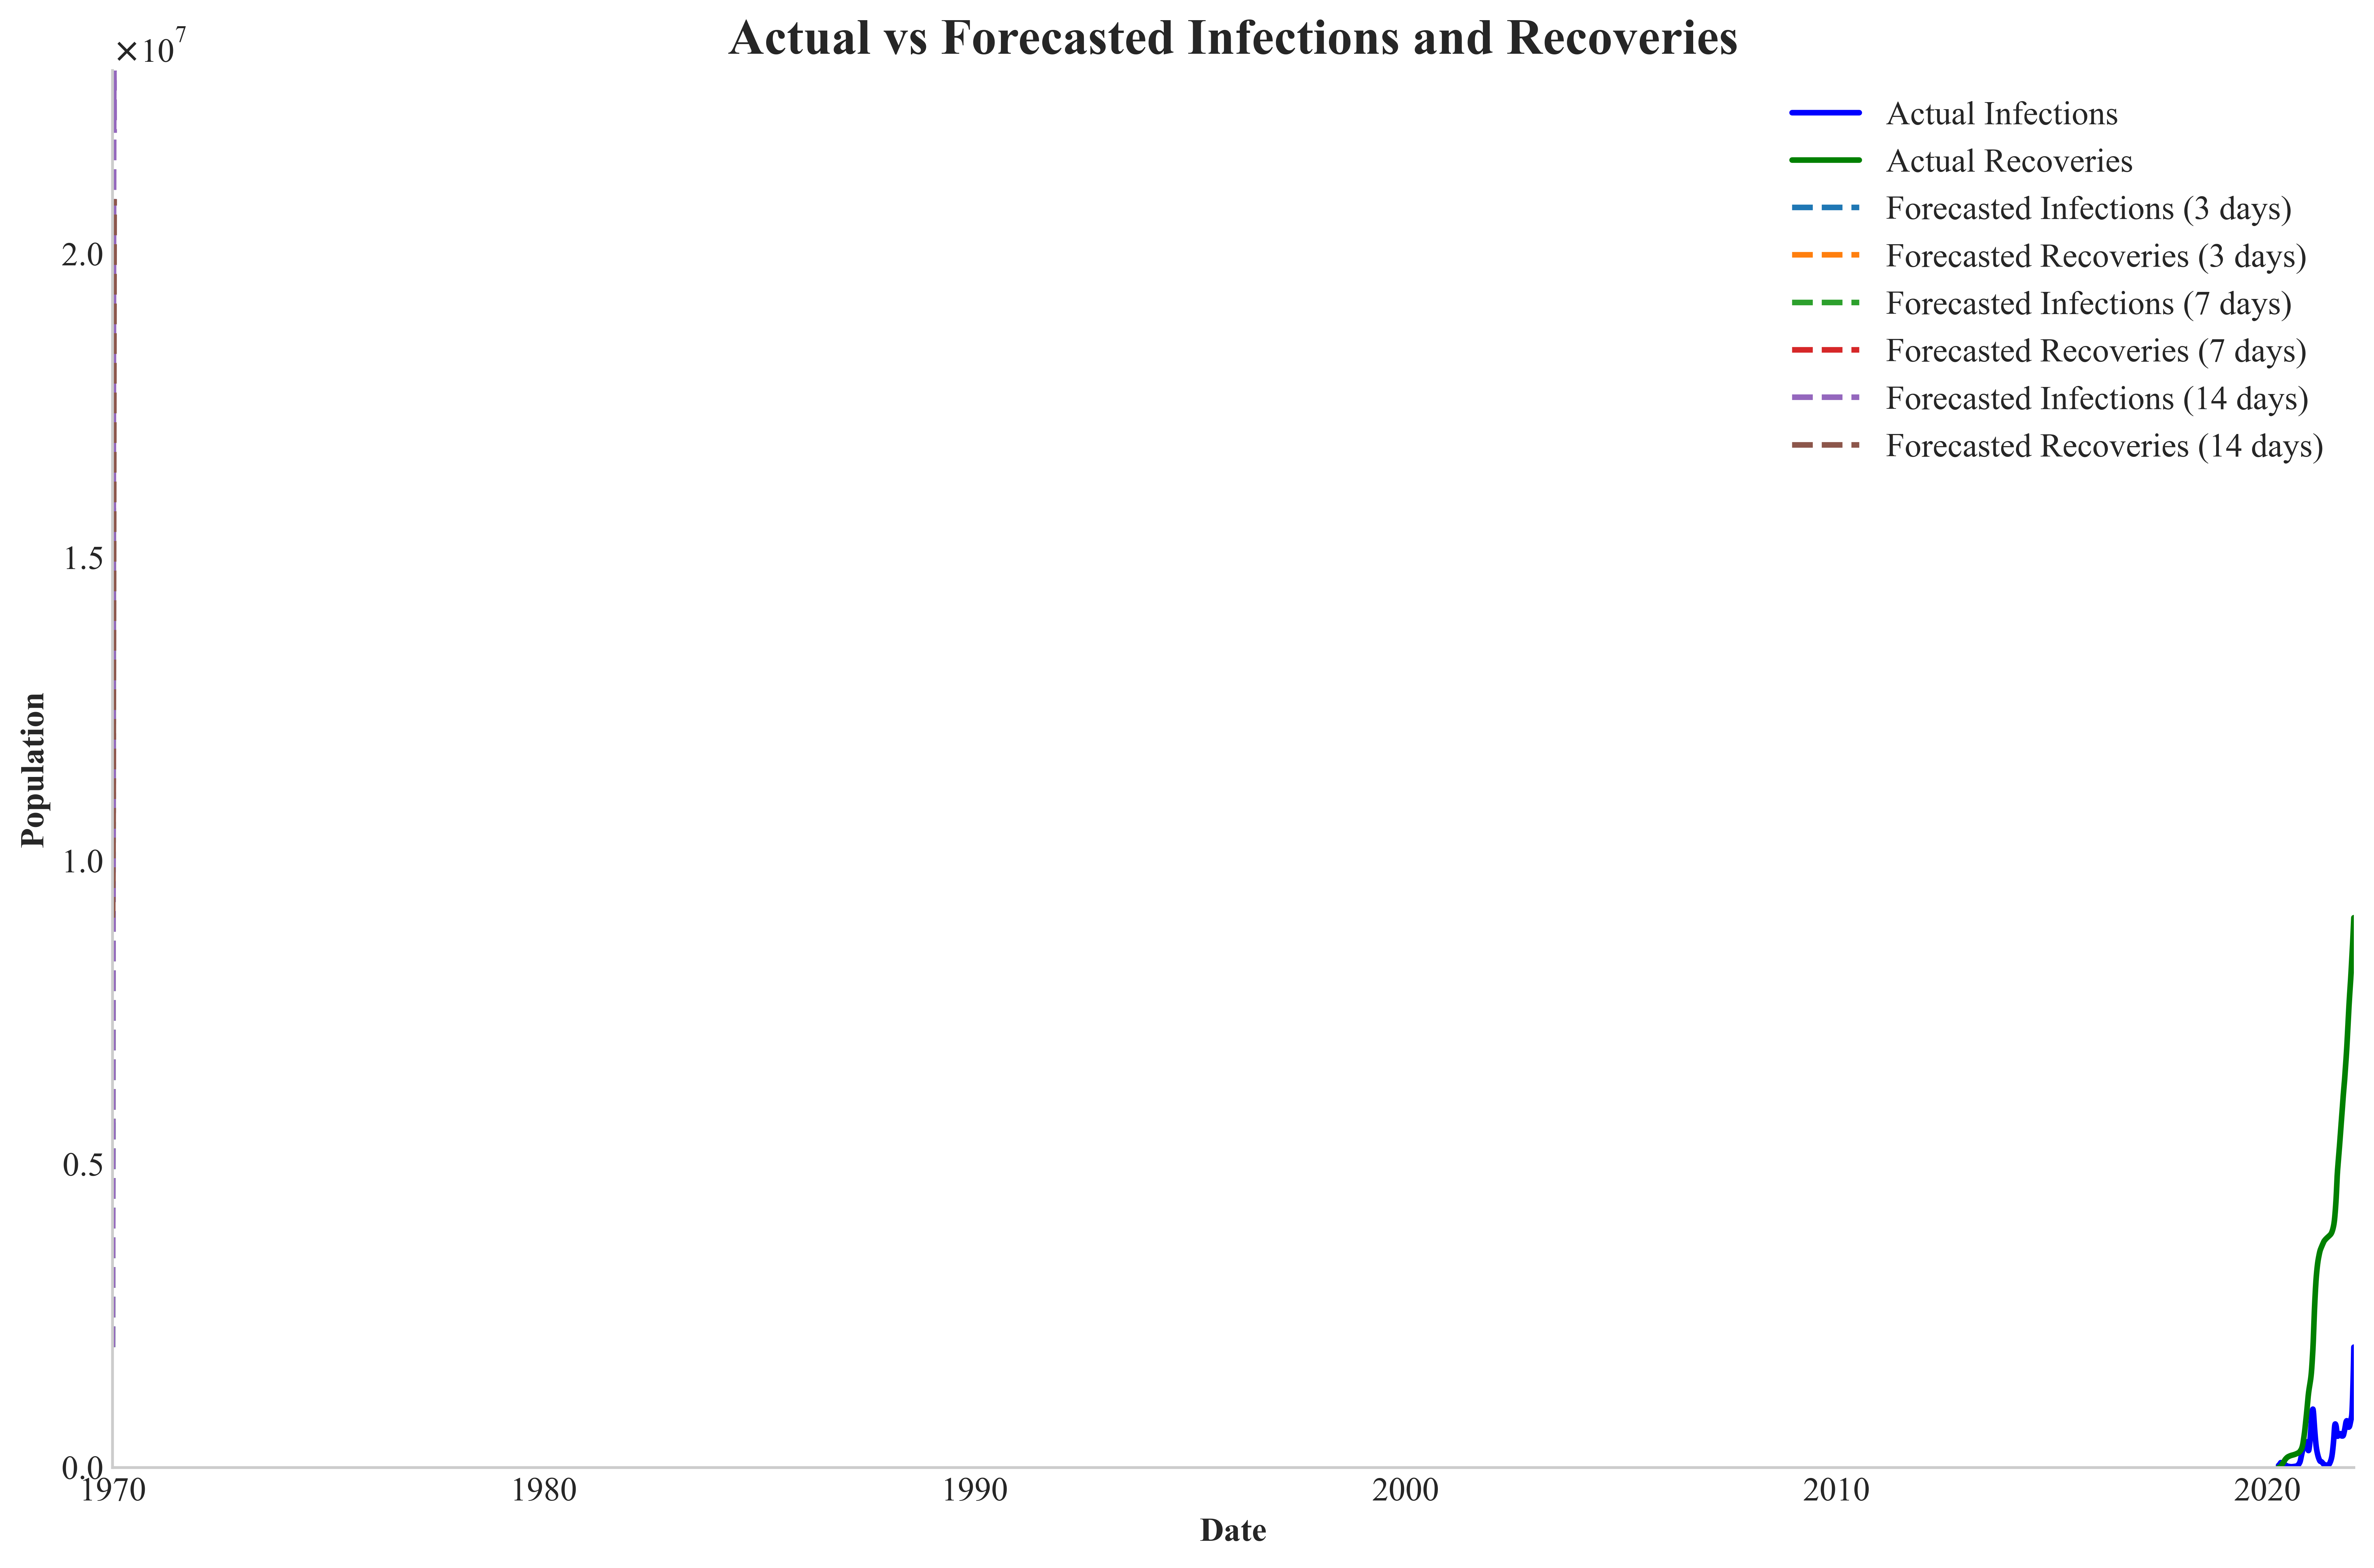

In [85]:
# plot the forecasted values for each compartment over the forecast period 3 days over the actual values for infection and recovery compar  the actual values

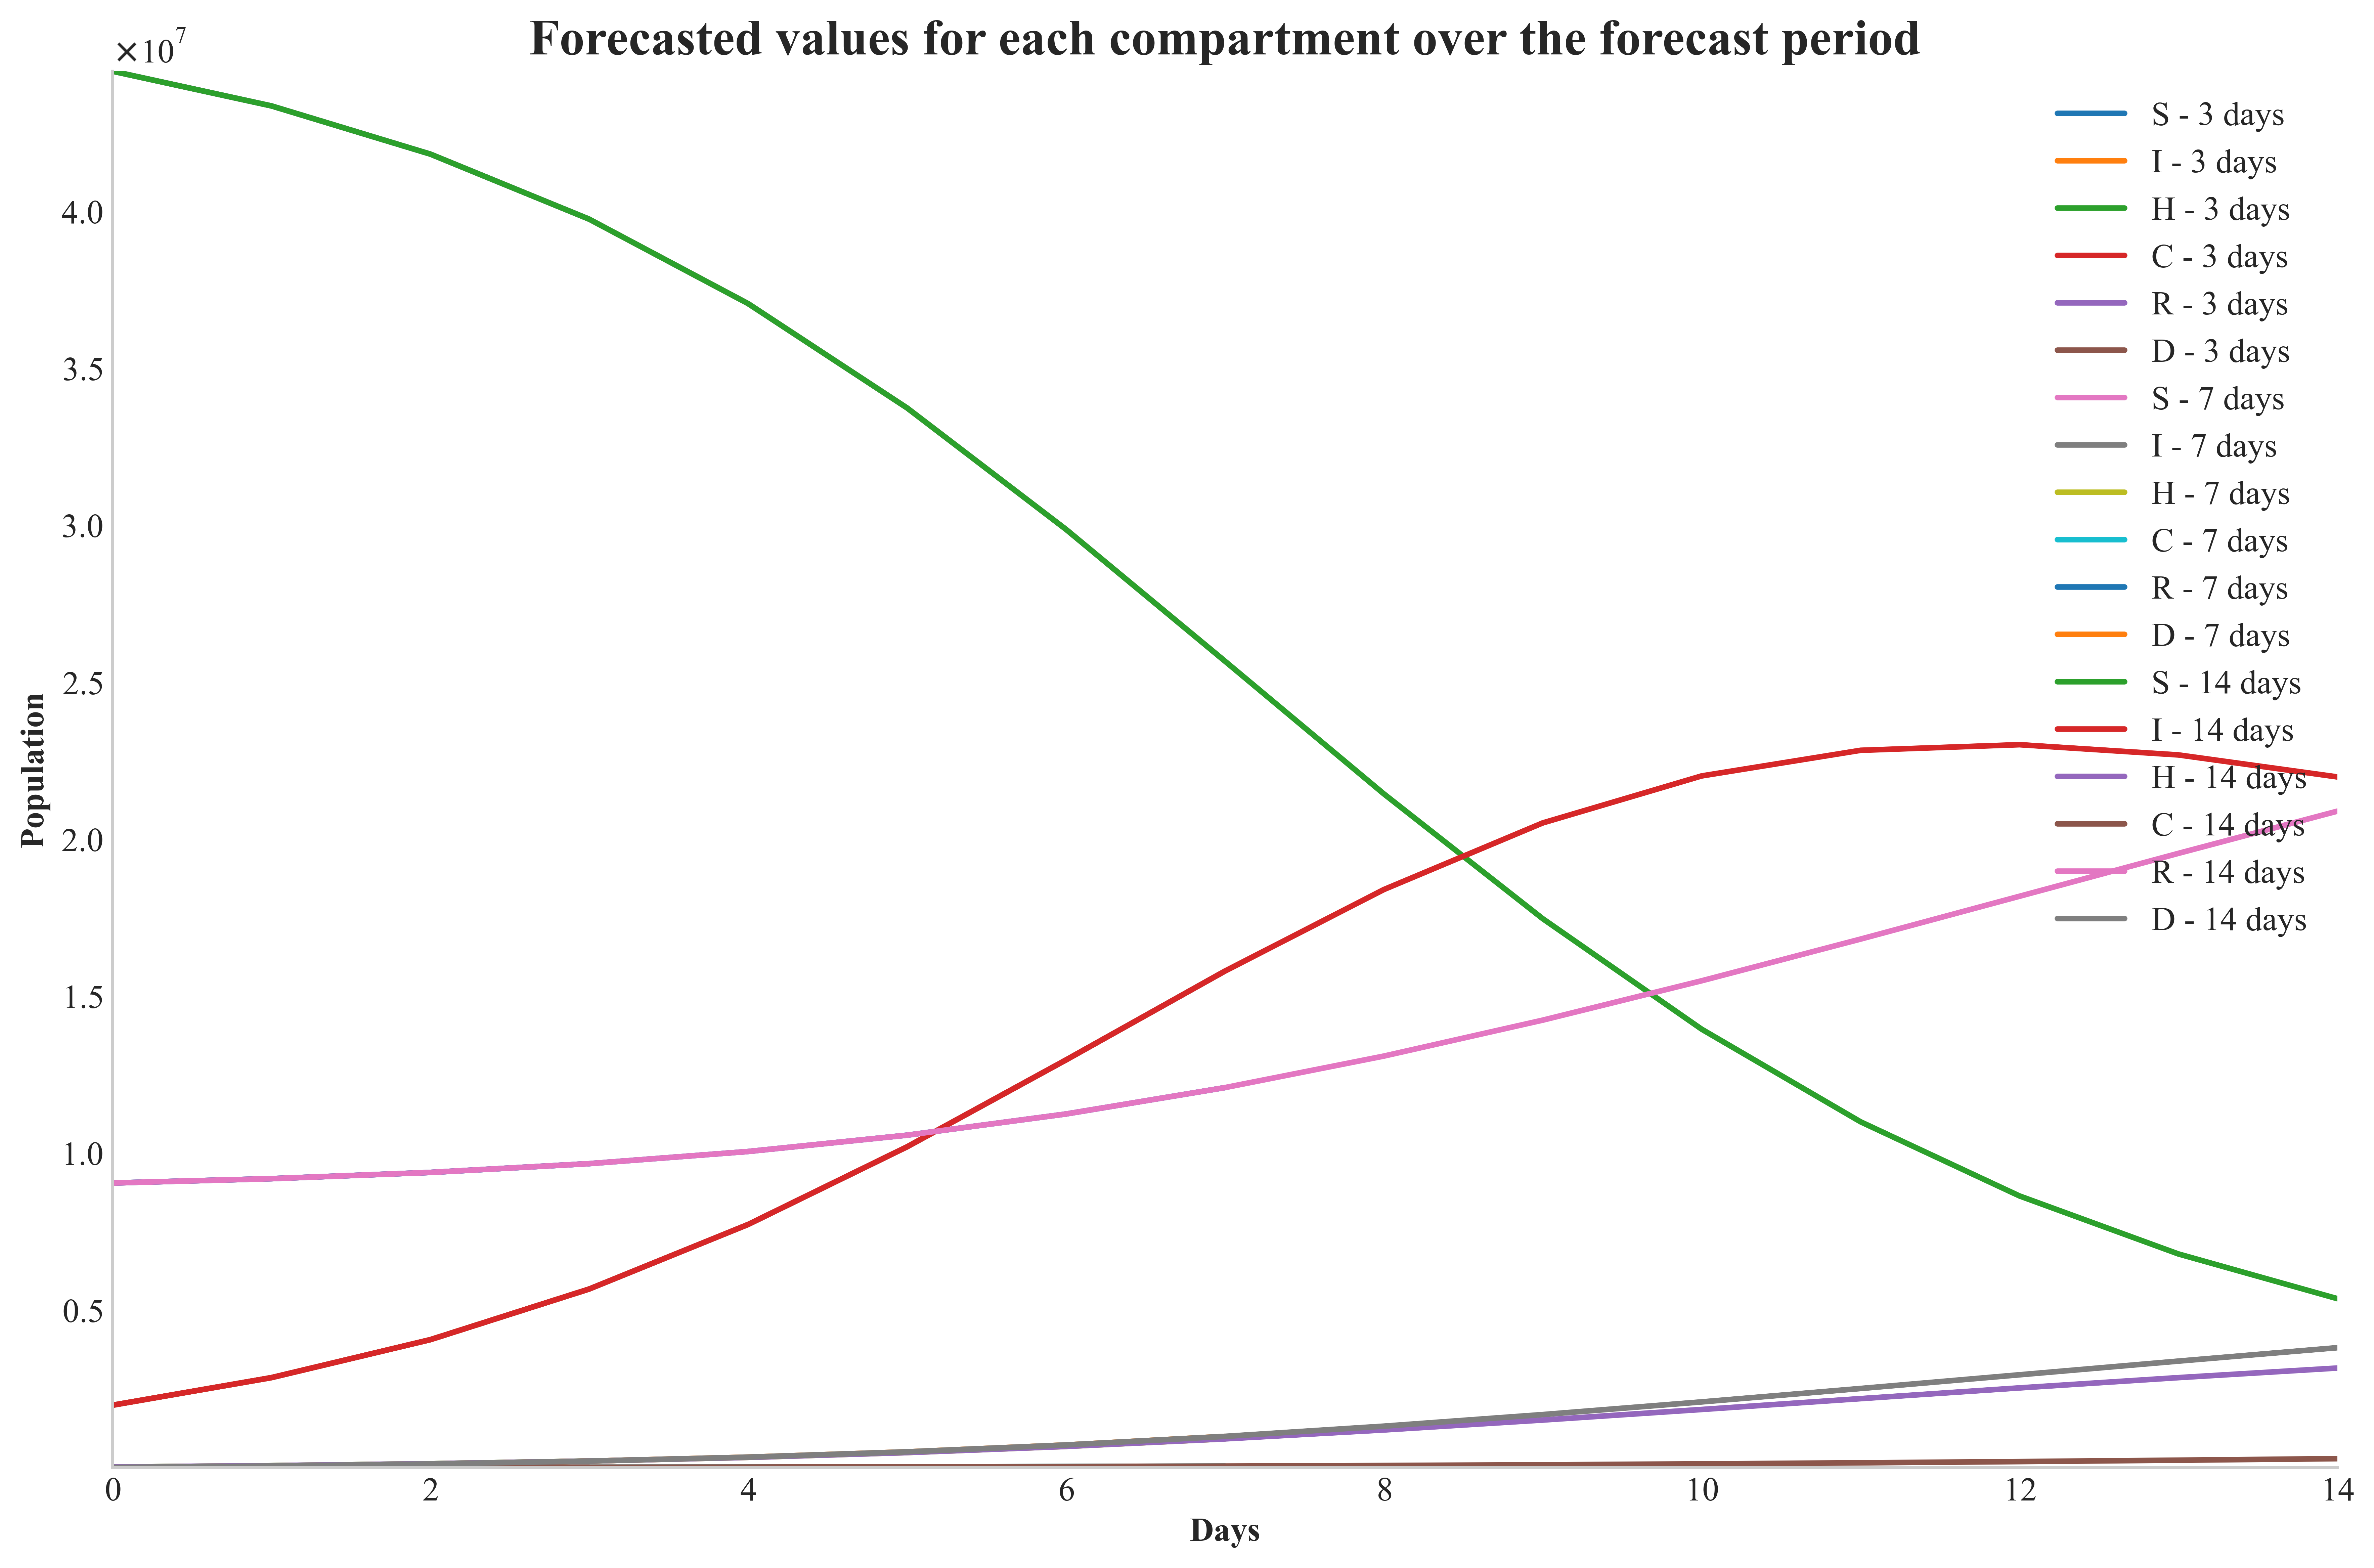

In [79]:
# Plotting the forecasted values for each compartment over the forecast period for 3, 7, and 14 days ahead using the validation data as the actual values
for days, (t_future, forecast) in forecasts.items():
    plt.figure(figsize=(10, 6))
    
    plt.plot(t_future, forecast[0], label="S(t) Forecast")


In [75]:
# Population
N = 56171302

# Forecasting for 3, 7, and 14 days
forecast_days = [3, 7, 14]
forecasts = {day: forecast_model(initial_conditions, model_params, day, N) for day in forecast_days}

ValueError: could not broadcast input array from shape (6,1) into shape (6,)